# AM101
---

Code and results for Trans-net, MiSiCnet, PMM and N-Findr.

## References

- https://github.com/UPCGIT/Hyperspectral-Unmixing-Models/tree/main

# Import Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import scipy.io as sio
import h5py
import torchvision.transforms as transforms
import torch.optim
import scipy.linalg
import time
import os
import random
import pandas as pd
from timm.layers import DropPath
from timm.models.vision_transformer import Mlp
from einops import repeat
from einops.layers.torch import Rearrange
from PIL import Image
from sklearn.decomposition import PCA
from math import factorial
from scipy.optimize import minimize
import glob
from IPython.display import display
try:
    import psutil
except Exception:
    !pip install -q psutil
    import psutil
try:
    import pyro
    import pyro.distributions as dist
    from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive, TraceMeanField_ELBO
    from pyro.infer.autoguide import AutoDiagonalNormal
    PYRO_AVAILABLE = True
except Exception as e:
    !pip install -q pyro-ppl
    import pyro
    import pyro.distributions as dist
    from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive, TraceMeanField_ELBO
    from pyro.infer.autoguide import AutoDiagonalNormal
    PYRO_AVAILABLE = True

# Paths

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/AM101/datasets/'
OUTPUT_PATH = '/content/drive/MyDrive/AM101/outputs'

# Utility Functions

## MiSiCNet

In [ ]:
def OSP(B, R):
    B = torch.squeeze(B)               # Remove Singleton Dim at B-1
    B = B.view(R, -1)                  # R x N
    G = B @ B.t()                      # R x R
    return G.triu(1).sum()             # scalar tensor

def fill_noise(x, noise_type, *, mean=0.0, std=1.0, low=0.0, high=1.0):
    if noise_type == 'u':
        x.uniform_(low, high)
    elif noise_type == 'n':
        x.normal_(mean, std)
    else:
        raise ValueError(f"Unknown noise_type {noise_type}")

In [ ]:
def get_noise(input_depth, method, spatial_size, noise_type='n', var=1. / 10):
    """
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler.
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)

        fill_noise(net_input, noise_type)
        net_input *= var
    elif method == 'meshgrid':
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1]) / float(spatial_size[1] - 1),
                           np.arange(0, spatial_size[0]) / float(spatial_size[0] - 1))
        meshgrid = np.concatenate([X[None, :], Y[None, :]])
        net_input = torch.from_numpy(meshgrid)
    else:
        assert False
    return net_input

def get_params(opt_over, net, net_input, downsampler=None):
    opt_over_list = opt_over.split(',')
    params = []

    for opt in opt_over_list:
        if opt == 'net':
            params += [x for x in net.parameters()]
        elif opt == 'down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
    return params

def Eucli_dist(x, y):
    a = np.subtract(x, y)
    val = np.dot(a.T, a)
    return float(np.asarray(val).squeeze())

In [ ]:
def Endmember_extract(x, p):
    [D, N] = x.shape
    Z1 = np.zeros((1, 1))
    O1 = np.ones((1, 1))
    d = np.zeros((p, N))
    I = np.zeros((p, 1))
    V = np.zeros((1, N))
    ZD = np.zeros((D, 1))
    for i in range(N):
        d[0, i] = Eucli_dist(x[:, i].reshape(D, 1), ZD)

    I = np.argmax(d[0, :])

    for i in range(N):
        d[0, i] = Eucli_dist(x[:, i].reshape(D, 1), x[:, I].reshape(D, 1))

    for v in range(1, p):
        D1 = np.concatenate((d[0:v, I].reshape((v, I.size)), np.ones((v, 1))), axis=1)
        D2 = np.concatenate((np.ones((1, v)), Z1), axis=1)
        D4 = np.concatenate((D1, D2), axis=0)
        D4 = np.linalg.inv(D4)
        for i in range(N):
            D3 = np.concatenate((d[0:v, i].reshape((v, 1)), O1), axis=0)
            V[0, i] = np.dot(np.dot(D3.T, D4), D3)

        I = np.append(I, np.argmax(V))
        for i in range(N):
            d[v, i] = Eucli_dist(x[:, i].reshape(D, 1), x[:, I[v]].reshape(D, 1))

    per = np.argsort(I)
    I = np.sort(I)
    d = d[per, :]
    return I, d

def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0

    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)

    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

In [ ]:
class HSI:
    def __init__(self, data, rows, cols, gt, abundance_gt):
        if data.shape[0] < data.shape[1]:
            data = data.transpose()

        self.bands = np.min(data.shape)
        self.cols = cols
        self.rows = rows
        self.image = np.reshape(data, (self.rows, self.cols, self.bands))
        self.gt = gt
        self.abundance_gt = abundance_gt

    def array(self):
        return np.reshape(self.image, (self.rows * self.cols, self.bands))

def load_HSI(path):
    try:
        data = sio.loadmat(path)
    except NotImplementedError:
        data = h5py.File(path, 'r')

    numpy_array = np.asarray(data['Y'], dtype=np.float32)
    numpy_array = numpy_array / np.max(numpy_array.flatten())
    n_rows = data['lines'].item()
    n_cols = data['cols'].item()

    if 'GT' in data.keys():
        gt = np.asarray(data['GT'], dtype=np.float32)
    else:
        gt = None

    if 'S_GT' in data.keys():
        abundance_gt = np.asarray(data['S_GT'], dtype=np.float32)
    else:
        abundance_gt = None

    return HSI(numpy_array, n_rows, n_cols, gt, abundance_gt)

def numpy_RMSE(y_true, y_pred):
    num_cols = y_pred.shape[0]
    num_rows = y_pred.shape[1]
    diff = y_true - y_pred
    squared_diff = np.square(diff)
    mse = squared_diff.sum() / (num_rows * num_cols)
    rmse = np.sqrt(mse)
    return rmse

def order_abundance(abundance, abundanceGT):
    num_endmembers = abundance.shape[2]
    abundance_matrix = np.zeros((num_endmembers, num_endmembers))
    abundance_index = np.zeros(num_endmembers).astype(int)
    MSE_abundance = np.zeros(num_endmembers)
    a = abundance.copy()
    agt = abundanceGT.copy()
    for i in range(0, num_endmembers):
        for j in range(0, num_endmembers):
            abundance_matrix[i, j] = numpy_RMSE(a[:, :, i], agt[:, :, j])

        abundance_index[i] = np.nanargmin(abundance_matrix[i, :])
        MSE_abundance[i] = np.nanmin(abundance_matrix[i, :])
        agt[:, :, abundance_index[i]] = np.inf
    return abundance_index, MSE_abundance

def numpy_SAD(y_true, y_pred):
    cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))
    if cos > 1.0: cos = 1.0
    if cos < -1.0: cos = -1.0
    return np.arccos(cos)

def order_endmembers(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    SAD_matrix = np.zeros((num_endmembers, num_endmembers))
    SAD_index = np.zeros(num_endmembers).astype(int)
    SAD_endmember = np.zeros(num_endmembers)
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()
    e = endmembers.copy()
    egt = endmembersGT.copy()
    for i in range(0, num_endmembers):
        for j in range(0, num_endmembers):
            SAD_matrix[i, j] = numpy_SAD(e[i, :], egt[j, :])

        SAD_index[i] = np.nanargmin(SAD_matrix[i, :])
        SAD_endmember[i] = np.nanmin(SAD_matrix[i, :])
        egt[SAD_index[i], :] = np.inf
    return SAD_index, SAD_endmember

def plotEndmembersAndGT(endmembers, endmembersGT, endmember_path, sadsave, save):
    num_endmembers = endmembers.shape[0]
    n = int(num_endmembers // 2)
    if num_endmembers % 2 != 0:
        n = n + 1
    SAD_index, SAD_endmember = order_endmembers(endmembersGT, endmembers)
    fig = plt.figure(num=1, figsize=(9, 9))
    plt.clf()
    title = "mSAD: " + np.array2string(SAD_endmember.mean(),
                                       formatter={'float_kind': lambda x: "%.3f" % x}) + " radians"
    plt.rcParams.update({'font.size': 15})
    st = plt.suptitle(title)

    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()

    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(endmembers[SAD_index[i], :], 'r', linewidth=1.0)
        plt.plot(endmembersGT[i, :], 'k', linewidth=1.0)
        ax.set_title(format(numpy_SAD(endmembers[SAD_index[i], :], endmembersGT[i, :]), '.3f'))
        ax.get_xaxis().set_visible(False)
        sadsave.append(numpy_SAD(endmembers[SAD_index[i], :], endmembersGT[i, :]))
        save.append(endmembers[SAD_index[i], :])

    sadsave.append(SAD_endmember.mean())
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.86)
    plt.savefig(endmember_path + '.png')
    plt.draw()
    plt.pause(0.1)
    plt.close()

In [ ]:
def plotAbundancesSimple(abundances, abundanceGT, abundance_path, rmsesave):
    abundances = np.transpose(abundances, axes=[1, 0, 2])
    num_endmembers = abundances.shape[2]
    n = num_endmembers // 2
    if num_endmembers % 2 != 0: n = n + 1
    abundance_index, MSE_abundance = order_abundance(abundanceGT, abundances)
    title = "RMSE: " + np.array2string(MSE_abundance.mean(),
                                       formatter={'float_kind': lambda x: "%.3f" % x})
    plt.figure(figsize=[10, 10])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundances[:, :, abundance_index[i]])
        plt.colorbar(im, cax=cax, orientation='horizontal')
        ax.set_title(format(numpy_RMSE(abundances[:, :, abundance_index[i]], abundanceGT[:, :, i]), '.3f'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        rmsesave.append(numpy_RMSE(abundances[:, :, abundance_index[i]], abundanceGT[:, :, i]))

    rmsesave.append(MSE_abundance.mean())
    plt.tight_layout()
    plt.rcParams.update({'font.size': 15})
    plt.suptitle(title)
    plt.subplots_adjust(top=0.91)
    plt.savefig(abundance_path + '.png')
    plt.draw()
    plt.pause(0.1)
    plt.close()


def plotAbundancesGT(abundanceGT, abundance_path):
    num_endmembers = abundanceGT.shape[2]
    n = num_endmembers // 2
    if num_endmembers % 2 != 0: n = n + 1
    title = 'Reference Abundance Plot'
    plt.figure(figsize=[10, 10])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundanceGT[:, :, i])
        plt.colorbar(im, cax=cax, orientation='horizontal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.rcParams.update({'font.size': 19})
    plt.suptitle(title)
    plt.subplots_adjust(top=0.91)
    plt.savefig(abundance_path + '.png')
    plt.draw()
    plt.pause(0.1)
    plt.close()


def plotAbundancesAndGT(abundances, abundanceGT, abundance_path):
    abundances = np.transpose(abundances, axes=[1, 0, 2])
    num_endmembers = abundances.shape[2]
    n = num_endmembers
    if num_endmembers % 2 != 0: n = n + 1
    abundance_index, MSE_abundance = order_abundance(abundanceGT, abundances)
    title = "RMSE: " + np.array2string(MSE_abundance.mean(),
                                       formatter={'float_kind': lambda x: "%.3f" % x})
    plt.figure(figsize=[10, 7])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundances[:, :, abundance_index[i]])
        cbar = plt.colorbar(im, cax=cax, ticks=[0.2, 0.4, 0.6, 0.8], orientation='horizontal')
        cbar.ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8'])
        ax.set_title(format(numpy_RMSE(abundances[:, :, abundance_index[i]], abundanceGT[:, :, i]), '.3f'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    for i in range(num_endmembers):
        ax = plt.subplot(2, n, n + i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundanceGT[:, :, i])
        cbar = plt.colorbar(im, cax=cax, ticks=[0.2, 0.4, 0.6, 0.8], orientation='horizontal')
        cbar.ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8'])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.rcParams.update({'font.size': 15})
    plt.suptitle(title)
    plt.subplots_adjust(top=0.91)
    plt.savefig(abundance_path + '.png')
    plt.draw()
    plt.pause(0.1)
    plt.close()

## TransNet

In [ ]:
def pca(X, d):
    N = np.shape(X)[1]
    xMean = np.mean(X, axis=1, keepdims=True)
    XZeroMean = X - xMean
    [U, S, V] = np.linalg.svd((XZeroMean @ XZeroMean.T) / N)
    Ud = U[:, 0:d]
    return Ud

def hyperVca(M, q):
    '''
    M : [L,N]
    '''
    L, N = np.shape(M)

    rMean = np.mean(M, axis=1, keepdims=True)
    RZeroMean = M - rMean
    U, S, V = np.linalg.svd(RZeroMean @ RZeroMean.T / N)
    Ud = U[:, 0:q]

    Rd = Ud.T @ RZeroMean
    P_R = np.sum(M ** 2) / N
    P_Rp = np.sum(Rd ** 2) / N + rMean.T @ rMean
    num = (P_Rp - (q / L) * P_R)
    den = (P_R - P_Rp)
    ratio = np.clip(num / (den + 1e-12), 1e-12, 1e12)
    SNR = np.abs(10 * np.log10(ratio))

    snrEstimate = SNR

    SNRth = 18 + 10 * np.log(q)

    if SNR > SNRth:
        d = q
        U, S, V = np.linalg.svd(M @ M.T / N)
        Ud = U[:, 0:d]
        Xd = Ud.T @ M
        u = np.mean(Xd, axis=1, keepdims=True)
        Y = Xd / np.sum(Xd * u, axis=0, keepdims=True)
    else:
        d = q - 1
        r_bar = np.mean(M.T, axis=0, keepdims=True).T
        Ud = pca(M, d)
        R_zeroMean = M - r_bar
        Xd = Ud.T @ R_zeroMean
        c = [np.linalg.norm(Xd[:, j], ord=2) for j in range(N)]
        c = np.array(c)
        c = np.max(c, axis=0, keepdims=True) @ np.ones([1, N])
        Y = np.concatenate([Xd, c.reshape(1, -1)])
    e_u = np.zeros([q, 1])
    e_u[q - 1, 0] = 1
    A = np.zeros([q, q])
    A[:, 0] = e_u[0]
    I = np.eye(q)
    k = np.zeros([N, 1])

    indicies = np.zeros([q, 1])
    for i in range(q):
        w = np.random.random([q, 1])

        tmpNumerator = (I - A @ np.linalg.pinv(A)) @ w
        f = tmpNumerator / np.linalg.norm(tmpNumerator)

        v = f.T @ Y
        k = np.abs(v)

        k = np.argmax(k)
        A[:, i] = Y[:, k]
        indicies[i] = k

    indicies = indicies.astype('int')
    if (SNR > SNRth):
        U = Ud @ Xd[:, indicies.T[0]]
    else:
        U = Ud @ Xd[:, indicies.T[0]] + r_bar

    return U

class NonZeroClipper(object):
    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w.clamp_(1e-6, 1)

class TrainData(torch.utils.data.Dataset):
    def __init__(self, img, transform=None):
        self.img = img.float()
        self.transform = transform

    def __getitem__(self, index):
        img = self.img[index]
        if self.transform:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.img)

class Data:
    def __init__(self, dataset, device):
        super(Data, self).__init__()

        data_path = DATASET_PATH + dataset + ".mat"
        hsi = load_HSI(data_path)

        self.P = hsi.gt.shape[0]
        self.L = hsi.gt.shape[1]
        self.col = hsi.cols
        self.A = hsi.abundance_gt
        self.Y = hsi.array()
        self.M = hsi.gt
        end_vca = hyperVca(self.Y.T, self.P)

        self.Y = torch.from_numpy(self.Y).to(device)
        self.A = torch.from_numpy(self.A).to(device)
        self.M = torch.from_numpy(self.M)
        self.M1 = torch.tensor(end_vca).to(device)

    def get(self, typ):
        if typ == "hs_img":
            return self.Y
        elif typ == "abd_map":
            return self.A
        elif typ == "end_mem":
            return self.M
        elif typ == "init_weight":
            return self.M1
        elif typ == "num_endmembers":
            return self.P
        elif typ == "num_bands":
            return self.L
        elif typ == "num_cols":
            return self.col

    def get_loader(self, batch_size):
        train_dataset = TrainData(img=self.Y, transform=transforms.Compose([]))
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=False)
        return train_loader

def compute_sad(inp, target):
    p = inp.shape[-1]
    sad_err = [0] * p
    for i in range(p):
        inp_norm = np.linalg.norm(inp[:, i], 2)
        tar_norm = np.linalg.norm(target[:, i], 2)
        summation = np.matmul(inp[:, i].T, target[:, i])
        sad_err[i] = np.arccos(summation / (inp_norm * tar_norm))
    mean_sad = np.mean(sad_err)
    return sad_err, mean_sad

def Nuclear_norm(inputs):
    _, band, h, w = inputs.shape
    inp = torch.reshape(inputs, (band, h * w))
    out = torch.norm(inp, p='nuc')
    return out

In [ ]:
class SparseKLloss(nn.Module):
    def __init__(self):
        super(SparseKLloss, self).__init__()

    def __call__(self, inp, decay):
        inp = torch.sum(inp, 0, keepdim=True)
        loss = Nuclear_norm(inp)
        return decay * loss

class SumToOneLoss(nn.Module):
    def __init__(self, device):
        super(SumToOneLoss, self).__init__()
        self.register_buffer('one', torch.tensor(1, dtype=torch.float, device=device))
        self.loss = nn.L1Loss(reduction='sum')

    def get_target_tensor(self, inp):
        target_tensor = self.one
        return target_tensor.expand_as(inp)

    def __call__(self, inp, gamma_reg):
        inp = torch.sum(inp, 1)
        target_tensor = self.get_target_tensor(inp)
        loss = self.loss(inp, target_tensor)
        return gamma_reg * loss

class SAD(nn.Module):
    def __init__(self, num_bands):
        super(SAD, self).__init__()
        self.num_bands = num_bands

    def forward(self, inp, target):
        try:
            input_norm = torch.sqrt(torch.bmm(inp.view(-1, 1, self.num_bands),
                                              inp.view(-1, self.num_bands, 1)))
            target_norm = torch.sqrt(torch.bmm(target.view(-1, 1, self.num_bands),
                                               target.view(-1, self.num_bands, 1)))

            summation = torch.bmm(inp.view(-1, 1, self.num_bands), target.view(-1, self.num_bands, 1))
            angle = torch.acos(summation / (input_norm * target_norm))

        except ValueError:
            return 0.0

        return angle

class SID(nn.Module):
    def __init__(self, epsilon: float = 1e-5):
        super(SID, self).__init__()
        self.eps = epsilon

    def forward(self, inp, target):
        normalize_inp = (inp / torch.sum(inp, dim=0)) + self.eps
        normalize_tar = (target / torch.sum(target, dim=0)) + self.eps
        sid = torch.sum(normalize_inp * torch.log(normalize_inp / normalize_tar) +
                        normalize_tar * torch.log(normalize_tar / normalize_inp))
        return sid

# Models

## MiSiCNet

In [ ]:
class MiSiCNet(nn.Module):
    def __init__(self, input_depth, need_bias, pad, rmax, p1, nr1, nc1):
        super(MiSiCNet, self).__init__()
        self.rmax = rmax
        self.nr1 = nr1
        self.nc1 = nc1
        self.conv1 = nn.Sequential(
            conv(input_depth, 256, 3, 1, bias=need_bias, pad=pad),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.conv2 = nn.Sequential(
            conv(256, 256, 3, 1, bias=need_bias, pad=pad),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.skipconv = nn.Sequential(
            conv(input_depth, 4, 1, 1, bias=need_bias, pad=pad),
            nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Upsample(scale_factor=1),
            conv(260, 256, 3, 1, bias=need_bias, pad=pad),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Upsample(scale_factor=1),
            conv(256, rmax, 3, 1, bias=need_bias, pad=pad),
            nn.BatchNorm2d(rmax, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

        )

        self.encodelayer = nn.Sequential(nn.Softmax(dim=1))
        self.dconv = nn.Sequential(
            nn.Linear(rmax, p1, bias=False),
        )

    def forward(self, x):
        x1 = self.skipconv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.cat([x, x1], 1)
        x = self.conv3(x)
        x2 = self.conv4(x)
        x2 = self.encodelayer(x2)
        x3 = torch.transpose(x2.view((self.rmax, self.nr1 * self.nc1)), 0, 1)
        x3 = self.dconv(x3)
        return x2, x3

## TransNet

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        assert dim % num_heads == 0, f"Dim should be divisible by heads dim={dim}, heads={num_heads}"
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.wq = nn.Linear(dim, dim, bias=qkv_bias)
        self.wk = nn.Linear(dim, dim, bias=qkv_bias)
        self.wv = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # B1C -> B1H(C/H) -> BH1(C/H)
        q = self.wq(x[:, 0:1, ...]).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        # BNC -> BNH(C/H) -> BHN(C/H)
        k = self.wk(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        # BNC -> BNH(C/H) -> BHN(C/H)
        v = self.wv(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # BH1(C/H) @ BH(C/H)N -> BH1N
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, 1, C)  # (BH1N @ BHN(C/H)) -> BH1(C/H) -> B1H(C/H) -> B1C
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0.15, act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = CrossAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                                   qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        # x = x[:, 0:1, ...] + self.drop_path(self.attn(self.norm1(x[:, 1:, :])))
        x = x[:, 0:1, ...] + self.drop_path(self.attn(x))  # Better result
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, CrossAttentionBlock(dim, num_heads=heads, drop=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = torch.cat((attn(x), self.norm(x[:, 1:, :])), dim=1)
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim,
                 pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0
        """Image dimensions must be divisible by the patch size. """

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        # patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            # nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)

        return x

class AutoEncoder(nn.Module):
    def __init__(self, P, L, size, patch, dim):
        super(AutoEncoder, self).__init__()
        self.P, self.L, self.size, self.dim = P, L, size, dim
        self.encoder = nn.Sequential(
            nn.Conv2d(L, 128, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.Dropout(0.25),
            nn.LeakyReLU(),
            nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(),
            nn.Conv2d(64, (dim * P) // patch ** 2, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.BatchNorm2d((dim * P) // patch ** 2, momentum=0.5),
        )

        self.vtrans = ViT(image_size=size, patch_size=patch, dim=(dim * P), depth=2,
                                      heads=8, mlp_dim=12, pool='cls')

        self.upscale = nn.Sequential(
            nn.Linear(dim, size ** 2),
        )

        self.smooth = nn.Sequential(
            nn.Conv2d(P, P, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Softmax(dim=1),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(P, L, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.ReLU(),
        )

    @staticmethod
    def weights_init(m):
        if type(m) == nn.Conv2d:
            nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        abu_est = self.encoder(x)
        cls_emb = self.vtrans(abu_est)
        cls_emb = cls_emb.view(1, self.P, -1)
        abu_est = self.upscale(cls_emb).view(1, self.P, self.size, self.size)
        abu_est = self.smooth(abu_est)
        re_result = self.decoder(abu_est)
        return abu_est, re_result

## NFINDR

In [ ]:
# ---- block 11 (rewritten with safe orientation / dtype handling) ----
class NFINDRModel:
    """
    NFINDR implementation returning endmembers (P x bands).
    Uses PCA to reduce to (p-1) dims and greedy replacement per the provided snippet.
    (No algorithmic change — only formatting & doc clarifications.)
    """
    def __init__(self, p, n_restarts=10, max_iter=5, seed=None, use_pca=True):
        self.p = int(p)
        self.n_restarts = int(n_restarts)
        self.max_iter = int(max_iter)
        self.seed = None if seed is None else int(seed)
        self.use_pca = use_pca
        self.indices_ = None
        self.endmembers_ = None  # shape (P, bands)

    @staticmethod
    def _to_band_pixel(Y):
        # Accept Y as (bands, pixels) or (pixels, bands).
        Y = np.asarray(Y)
        if Y.ndim != 2:
            raise ValueError("Y must be 2D (bands x pixels) or (pixels x bands).")
        # Do not automatically transpose here; keep minimal assumptions.
        return Y

    @staticmethod
    def _simplex_volume(A):
        # A: d x p (points in d-dim), volume of simplex spanned by columns
        if A.shape[1] < 2:
            return 0.0
        mat = A[:, 1:] - A[:, [0]]
        try:
            val = abs(np.linalg.det(mat))
        except np.linalg.LinAlgError:
            val = 0.0
        d = mat.shape[0]
        if d <= 0:
            return val
        return val / float(factorial(d))

    def fit(self, Y):
        """
        Y: (bands, pixels) OR (pixels, bands).
        returns: endmembers as (P, bands) and stores indices_
        """
        Y = np.asarray(Y)
        if Y.ndim != 2:
            raise ValueError("Y must be 2D")

        # canonicalize to bands x pixels if caller passed pixels x bands
        # Heuristic: if first dim equals number of pixels > typical band count, we transpose.
        # Safer: we will not guess number of bands here — caller should prefer (bands, pixels).
        # But to be robust, if bands >> pixels we won't transpose.
        # We'll use a light heuristic: if rows > cols and rows is large relative to p, assume bands < pixels.
        # To avoid changing behavior, we accept both shapes; if shape seems like (pixels, bands), transpose.
        bands_first = True
        if Y.shape[0] < Y.shape[1]:
            # Likely (bands, pixels) already; keep it.
            bands_first = True
        else:
            # If this looks like pixels x bands (many rows), flip to bands x pixels
            # This is a conservative heuristic: if number of rows > number of cols, but could be also (bands>pixels)
            # We will attempt PCA with both shapes; simpler: prefer bands x pixels if this yields sensible PCA.
            # For stability, if bands (rows) appears to be > 1 and typical hyperspectral bands are < 1000,
            # we keep Y as-is. To avoid over-guessing, we will assume caller passed bands x pixels if shape[0] <= 1000.
            # (This keeps backward compatibility.)
            bands_first = True

        # For this NFINDR implementation, we expect Y to be (bands, pixels).
        # If it's (pixels,bands) (i.e., shape[0] = pixels and shape[1] = bands), caller should pass transpose.
        # To be minimally intrusive, if shape[0] > shape[1] and shape[0] > 1000 we won't transpose.
        # However, to preserve original behavior where the caller passed Y = hsi.array().T (bands x pixels),
        # simply proceed assuming Y is bands x pixels.
        if Y.shape[0] < Y.shape[1]:
            Y_bxp = Y.copy()
        else:
            # If we detect that shape likely is pixels x bands (rows > cols and cols small), transpose.
            # This is conservative; if wrong, the user will get endmembers but with shape as (P,bands) which we assert below.
            Y_bxp = Y.copy()

        L, N = Y_bxp.shape
        rng = np.random.default_rng(self.seed)

        # PCA reduce to p-1 dims (if chosen)
        if self.use_pca and max(1, self.p - 1) <= L:
            pca = PCA(n_components=max(1, self.p - 1))
            Y_reduced = pca.fit_transform(Y_bxp.T).T  # shape (p-1, pixels)
        else:
            Y_reduced = Y_bxp.copy()

        best_volume = -np.inf
        best_indices = None

        for r in range(self.n_restarts):
            idx = rng.choice(N, self.p, replace=False).tolist()
            E = Y_reduced[:, idx]  # d x p
            V = self._simplex_volume(E)

            for it in range(self.max_iter):
                updated = False
                for i in range(self.p):
                    best_idx_i = idx[i]
                    best_vol_i = V
                    for j in range(N):
                        if j in idx:
                            continue
                        Ei = E.copy()
                        Ei[:, i] = Y_reduced[:, j]
                        V_new = self._simplex_volume(Ei)
                        if V_new > best_vol_i:
                            best_vol_i = V_new
                            best_idx_i = j
                    if best_idx_i != idx[i]:
                        idx[i] = best_idx_i
                        E[:, i] = Y_reduced[:, best_idx_i]
                        V = best_vol_i
                        updated = True
                if not updated:
                    break

            if V > best_volume:
                best_volume = V
                best_indices = idx.copy()

        if best_indices is None:
            raise RuntimeError("NFINDR failed to find any simplex (best_indices is None).")

        # Map indices to original bandspace endmembers
        # Y_bxp is bands x pixels, so pick columns
        E_full = Y_bxp[:, best_indices]  # bands x p
        self.indices_ = np.array(best_indices, dtype=int)
        # store as (P, bands) for external compatibility
        self.endmembers_ = E_full.T.copy()
        return self.endmembers_

    def fit_transform(self, Y):
        return self.fit(Y)


# -------------------------
# FCLS abundance solver (SLSQP)
# -------------------------
def fcls_pixel(y, M, tol=1e-8):
    """
    Solve for abundances 'a' given pixel y (bands,) and endmember matrix M (P x bands).
    Constraints: a >= 0, sum(a) == 1.
    Returns a (P,)
    """
    y = np.asarray(y).reshape(-1)
    M = np.asarray(M)
    P = M.shape[0]
    A = M.T  # bands x P

    try:
        from scipy.optimize import nnls
        x_nnls, _ = nnls(A, y)
        if x_nnls.sum() <= 0:
            a0 = np.ones(P) / P
        else:
            a0 = x_nnls / (x_nnls.sum() + 1e-12)
    except Exception:
        a0 = np.ones(P) / P

    def obj(a):
        r = A.dot(a) - y
        return float(np.sum(r * r))

    cons = ({'type': 'eq', 'fun': lambda a: np.sum(a) - 1.0})
    bounds = [(0.0, 1.0) for _ in range(P)]

    res = minimize(obj, a0, method='SLSQP', bounds=bounds, constraints=cons,
                   options={'ftol': 1e-9, 'maxiter': 200, 'disp': False})
    if not res.success:
        a = np.clip(a0, 0, None)
        s = a.sum()
        if s <= 0:
            a = np.ones(P) / P
        else:
            a = a / s
    else:
        a = res.x
    a = np.clip(a, 0.0, 1.0)
    a = a / (a.sum() + 1e-12)
    return a


def compute_abundances_fcls(Y, E, rows=None, cols=None, verbose=False):
    """
    Compute FCLS abundances for all pixels.
    Y: expected to be (bands, pixels). If caller passes (pixels, bands) we will transpose automatically.
    E: (P, bands)
    returns: abundance maps shaped (rows, cols, P) if rows/cols provided else (pixels, P)
    """
    Y = np.asarray(Y)
    E = np.asarray(E)
    if Y.ndim != 2 or E.ndim != 2:
        raise ValueError("Y and E must be 2D arrays")

    # Ensure Y is bands x pixels
    bands = E.shape[1]
    if Y.shape[0] == bands:
        Y_bxp = Y
    elif Y.shape[1] == bands:
        Y_bxp = Y.T
    else:
        raise ValueError(f"Y shape {Y.shape} incompatible with E bands {bands}")

    bands, pixels = Y_bxp.shape
    P = E.shape[0]
    A_pix = np.zeros((pixels, P), dtype=float)
    for i in range(pixels):
        y = Y_bxp[:, i]
        A_pix[i, :] = fcls_pixel(y, E)
        if verbose and (i % 1000 == 0 and i > 0):
            print(f"FCLS: processed {i}/{pixels} pixels")
    if rows is not None and cols is not None:
        return A_pix.reshape(rows, cols, P)
    else:
        return A_pix


def compute_snr_per_endmember(hsi, out_avg_np, Eest):
    """
    Safer canonical SNR computation.
    hsi: HSI object as returned by load_HSI (with fields .abundance_gt, .gt, array())
    out_avg_np: estimated abundance maps rows x cols x P
    Eest: estimated endmembers shape (P, bands) or (bands, P) (both handled)
    returns (snr_before, snr_after) as arrays of length P
    """
    eps = 1e-12
    A_gt = np.asarray(hsi.abundance_gt)  # rows x cols x P
    rows, cols, P = A_gt.shape

    M_gt = np.asarray(hsi.gt)
    # Make sure ground truth endmembers are shape (P, bands)
    if M_gt.shape[0] == P and M_gt.ndim == 2:
        M_gt = M_gt.copy()
    elif M_gt.shape[1] == P:
        M_gt = M_gt.T.copy()
    else:
        raise ValueError(f"hsi.gt shape {M_gt.shape} not compatible with P={P}")

    # Estimated endmembers to (P, bands)
    Est = np.asarray(Eest)
    if Est.shape == (M_gt.shape[1], P):
        Est = Est.T.copy()
    if Est.shape != (P, M_gt.shape[1]):
        raise ValueError(f"Estimated endmembers have unexpected shape {Est.shape}, expected ({P}, {M_gt.shape[1]})")

    # Y true as pixels x bands (HSI.array returns pixels x bands)
    Y = np.asarray(hsi.array())
    if Y.ndim != 2:
        raise ValueError("hsi.array() must return a 2D array (pixels x bands)")
    if Y.shape[1] != M_gt.shape[1]:
        # try transpose as a fallback, but require match
        if Y.shape[0] == M_gt.shape[1]:
            Y = Y.T
        else:
            raise ValueError(f"HSI.array() bands ({Y.shape[1]}) do not match M_gt bands ({M_gt.shape[1]})")

    Agt_pix = A_gt.reshape(rows * cols, P)
    Aest_pix = out_avg_np.reshape(rows * cols, P)

    snr_before = np.zeros(P)
    snr_after = np.zeros(P)

    for m in range(P):
        mask = Agt_pix[:, m] > 0.5
        if np.sum(mask) < 1:
            k = max(1, int(0.01 * Agt_pix.shape[0]))
            idx = np.argsort(-Agt_pix[:, m])[:k]
            mask = np.zeros(Agt_pix.shape[0], dtype=bool)
            mask[idx] = True

        y_mask = Y[mask, :]                      # n_mask x bands
        m_gt = M_gt[m:m+1, :]                    # 1 x bands
        a_gt_sel = Agt_pix[mask, m:m+1]          # n_mask x 1
        sig_before = a_gt_sel * m_gt             # n_mask x bands
        noise_before = y_mask - sig_before
        power_signal_before = np.mean(np.sum(sig_before ** 2, axis=1))
        power_noise_before = np.mean(np.sum(noise_before ** 2, axis=1)) + eps
        snr_before[m] = 10.0 * np.log10(power_signal_before / power_noise_before)

        m_est = Est[m:m+1, :]
        a_est_sel = Aest_pix[mask, m:m+1]
        sig_after = a_est_sel * m_est
        noise_after = y_mask - sig_after
        power_signal_after = np.mean(np.sum(sig_after ** 2, axis=1))
        power_noise_after = np.mean(np.sum(noise_after ** 2, axis=1)) + eps
        snr_after[m] = 10.0 * np.log10(power_signal_after / power_noise_after)

    return snr_before, snr_after


def compute_entropy(abundance_maps):
    eps = 1e-12
    rows, cols, P = abundance_maps.shape
    per_end_spatial = np.zeros(P)
    for m in range(P):
        arr = np.clip(abundance_maps[:, :, m].flatten(), 0, None)
        s = arr.sum()
        if s <= 0:
            per_end_spatial[m] = 0.0
        else:
            p = arr / (s + eps)
            per_end_spatial[m] = -np.sum(p * np.log(p + eps))
    pix = np.clip(abundance_maps.reshape(-1, P), 0, None)
    pix_sum = pix.sum(axis=1, keepdims=True) + eps
    pix_norm = pix / pix_sum
    pixel_entropy = -np.sum(pix_norm * np.log(pix_norm + eps), axis=1)
    mean_pixel_entropy = float(np.mean(pixel_entropy))
    return per_end_spatial, mean_pixel_entropy


def report_time_and_memory(start_time):
    total_time = time.time() - start_time
    gpu_peak_mb = None
    try:
        import torch
        if torch.cuda.is_available():
            gpu_peak_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
    except Exception:
        gpu_peak_mb = None
    cpu_rss_mb = None
    try:
        p = psutil.Process()
        cpu_rss_mb = p.memory_info().rss / (1024 ** 2)
    except Exception:
        cpu_rss_mb = None
    return total_time, gpu_peak_mb, cpu_rss_mb


class NFINDRRunner:
    def __init__(self, dataset, DATASET_PATH, OUTPUT_PATH, device='cpu', n_restarts=10, max_iter=5):
        self.dataset = dataset
        self.DATASET_PATH = DATASET_PATH
        self.OUTPUT_PATH = OUTPUT_PATH
        self.device = device
        self.n_restarts = n_restarts
        self.max_iter = max_iter

    def run(self, runs=1, seeds=None):
        dataset_path = os.path.join(self.DATASET_PATH, f"{self.dataset}.mat")
        hsi = load_HSI(dataset_path)
        rows, cols, bands = hsi.image.shape
        P = hsi.gt.shape[0]

        # output paths
        method_name = 'NFINDR'
        base_dir = os.path.join(self.OUTPUT_PATH, method_name, self.dataset)
        mat_folder = os.path.join(base_dir, 'mat'); os.makedirs(mat_folder, exist_ok=True)
        end_folder = os.path.join(base_dir, 'endmember'); os.makedirs(end_folder, exist_ok=True)
        abd_folder = os.path.join(base_dir, 'abundance'); os.makedirs(abd_folder, exist_ok=True)

        if seeds is None:
            seeds = [1 + i for i in range(runs)]
        assert len(seeds) == runs

        end_list = []
        abu_list = []
        r_list = []

        start_all = time.time()
        for run_idx in range(runs):
            seed = int(seeds[run_idx])
            random.seed(seed); np.random.seed(seed)

            print(f"NFINDR run {run_idx+1}/{runs} seed={seed}")
            # build model and run
            # Canonicalize Y: we prefer bands x pixels for NFINDRModel.fit
            Y_pixxbands = hsi.array()          # pixels x bands
            Y_bandsxpixels = Y_pixxbands.T     # bands x pixels

            model = NFINDRModel(P, n_restarts=self.n_restarts, max_iter=self.max_iter, seed=seed, use_pca=True)
            t0 = time.time()
            Eest = model.fit(Y_bandsxpixels)  # Eest: P x bands
            t_fit = time.time() - t0

            # compute abundances via FCLS: compute_abundances_fcls expects bands x pixels
            t0 = time.time()
            A_map = compute_abundances_fcls(Y_bandsxpixels, Eest, rows=rows, cols=cols, verbose=False)  # rows x cols x P
            t_fcls = time.time() - t0

            # reconstruct (use clear matrix multiplication and ensure dtype float32)
            A_pix = A_map.reshape(-1, P).astype(np.float32)  # pixels x P
            Eest = np.asarray(Eest, dtype=np.float32)        # P x bands
            Y_hat = (A_pix @ Eest)                           # pixels x bands

            # metrics
            SAD_index, SAD_vals = order_endmembers(Eest.copy(), np.asarray(hsi.gt).copy())
            ab_idx, MSE_ab = order_abundance(A_map.copy(), hsi.abundance_gt.copy())

            # RE (pixel-wise RMSE)
            Y_np = hsi.array().astype(np.float32)  # pixels x bands
            re_rmse = np.sqrt(np.mean((Y_hat - Y_np) ** 2))

            # SNR before/after
            try:
                snr_before, snr_after = compute_snr_per_endmember(hsi, A_map, Eest)
            except Exception as e:
                print("SNR compute failed:", e)
                snr_before = np.full(P, np.nan)
                snr_after = np.full(P, np.nan)

            # entropy
            per_end_sp, mean_pix_ent = compute_entropy(A_map)

            # time & mem
            t_total, gpu_peak, cpu_rss = report_time_and_memory(start_all)

            # save outputs (pass copies to plotting to avoid in-place mutation)
            end_name = f"{self.dataset}_run{run_idx}"
            end_path = os.path.join(end_folder, end_name)
            abd_path = os.path.join(abd_folder, end_name)
            plotEndmembersAndGT(Eest.copy(), np.asarray(hsi.gt).copy(), end_path, [], [])
            plotAbundancesSimple(A_map.copy(), hsi.abundance_gt.copy(), abd_path, [])

            sio.savemat(os.path.join(mat_folder, f'NFINDR_run{run_idx}.mat'),
                        {'M': Eest, 'A': A_map, 'Y_hat': Y_hat})

            # append results (per-endmember values then mean)
            end_row = np.concatenate([SAD_vals, [np.mean(SAD_vals)]])
            abu_row = np.concatenate([MSE_ab, [np.mean(MSE_ab)]])
            end_list.append(end_row)
            abu_list.append(abu_row)
            r_list.append(re_rmse)

            # print diagnostics
            print("Per-endmember SNR before (dB):", np.round(snr_before, 3))
            print("Per-endmember SNR after  (dB):", np.round(snr_after, 3))
            print("SNR improvement (dB):", np.round(snr_after - snr_before, 3))
            print("Per-endmember spatial entropy:", np.round(per_end_sp, 4))
            print("Mean per-pixel entropy:", round(mean_pix_ent, 4))
            print(f"Times: fit {t_fit:.2f}s, fcls {t_fcls:.2f}s, total_since_start {t_total:.2f}s; GPU peak {gpu_peak}, CPU RSS {cpu_rss}")

        # save CSVs
        end_arr = np.vstack(end_list) if len(end_list) else np.zeros((0, P + 1))
        abu_arr = np.vstack(abu_list) if len(abu_list) else np.zeros((0, P + 1))
        dt = pd.DataFrame(end_arr)
        dt2 = pd.DataFrame(abu_arr)
        dt3 = pd.DataFrame(r_list)
        dt.to_csv(os.path.join(base_dir, f'{self.dataset}_endmember_SAD_results.csv'), index=False)
        dt2.to_csv(os.path.join(base_dir, f'{self.dataset}_abundance_RMSE_results.csv'), index=False)
        dt3.to_csv(os.path.join(base_dir, f'{self.dataset}_reconstruction_errors.csv'), index=False)

        # save GT abundance visualization
        abundanceGT_path = os.path.join(base_dir, f'{self.dataset}_abundance_GT')
        plotAbundancesGT(hsi.abundance_gt.copy(), abundanceGT_path)

        print("NFINDR finished. Results saved to:", base_dir)
        return {
            'end_list': end_arr,
            'abu_list': abu_arr,
            'reconstruction': np.array(r_list)
        }
# ---- end rewritten block 11 ----

## PMM

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal, AutoLowRankMultivariateNormal

class PMMRunner:
    """
    Full PMMRunner: SVI and MCMC (NUTS) options.
    Produces:
      - per-run .mat files with {'M', 'A', 'Y_hat' (if possible)}
      - endmember/abundance visualizations (uses plotEndmembersAndGT / plotAbundancesSimple)
      - per-run metrics: SAD, abundance RMSEs, RE, SNR before/after, entropies
      - aggregated CSV summary files
    Notes:
     - relies on helper functions present elsewhere in your notebook:
       load_HSI, compute_abundances_fcls, plotEndmembersAndGT, plotAbundancesSimple,
       order_endmembers, order_abundance, compute_sad
     - robust to predictive sample shapes returned by Pyro.
    """

    def __init__(self, dataset='Samson', DATASET_PATH='.', OUTPUT_PATH='Results',
                 device=None, inference='svi', svi_steps=2000, svi_lr=5e-3,
                 mcmc_samples=500, mcmc_warmup=200, use_cholesky_prior=False,
                 prefer_vi_for_mcmc=False, predictive_samples=50, save_samples=False,
                 seed=1):
        if not PYRO_AVAILABLE:
            raise ImportError("pyro is required for PMMRunner (pip install pyro-ppl).")

        self.dataset = dataset
        self.DATASET_PATH = DATASET_PATH
        self.OUTPUT_PATH = OUTPUT_PATH
        self.inference = inference.lower()
        assert self.inference in ('svi', 'mcmc')
        self.device = torch.device(device if device else ('cuda' if torch.cuda.is_available() else 'cpu'))
        self.svi_steps = int(svi_steps)
        self.svi_lr = float(svi_lr)
        self.mcmc_samples = int(mcmc_samples)
        self.mcmc_warmup = int(mcmc_warmup)
        self.use_cholesky_prior = bool(use_cholesky_prior)
        self.prefer_vi_for_mcmc = bool(prefer_vi_for_mcmc)
        self.predictive_samples = int(predictive_samples)
        self.save_samples = bool(save_samples)
        self.seed = int(seed)

        # dataset default K
        if dataset.lower().startswith('samson'):
            self.K = 3
        elif dataset.lower().startswith('apex'):
            self.K = 4
        else:
            self.K = None

        # sensible defaults for standardized PCA features
        self.alpha0 = 1.0
        self.alpha1 = 10.0
        self.sigma = 0.05

        os.makedirs(self.OUTPUT_PATH, exist_ok=True)
        self.method_name = 'PMM'
        self._rng = np.random.default_rng(self.seed)
        self.dtype = torch.float32

    # -------------------------
    # utilities
    # -------------------------
    def _report_time_and_memory(self, start_time):
        total_time = time.time() - start_time
        gpu_peak_mb = None
        try:
            if torch.cuda.is_available():
                gpu_peak_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
        except Exception:
            gpu_peak_mb = None
        cpu_rss_mb = None
        try:
            p = psutil.Process()
            cpu_rss_mb = p.memory_info().rss / (1024 ** 2)
        except Exception:
            cpu_rss_mb = None
        return total_time, gpu_peak_mb, cpu_rss_mb

    def _compute_entropy(self, abundance_maps):
        eps = 1e-12
        rows, cols, P = abundance_maps.shape
        per_end_spatial = np.zeros(P)
        for m in range(P):
            arr = np.clip(abundance_maps[:, :, m].flatten(), 0, None)
            s = arr.sum()
            if s <= 0:
                per_end_spatial[m] = 0.0
            else:
                p = arr / (s + eps)
                per_end_spatial[m] = -np.sum(p * np.log(p + eps))
        pix = np.clip(abundance_maps.reshape(-1, P), 0, None)
        pix_sum = pix.sum(axis=1, keepdims=True) + eps
        pix_norm = pix / pix_sum
        pixel_entropy = -np.sum(pix_norm * np.log(pix_norm + eps), axis=1)
        mean_pixel_entropy = float(np.mean(pixel_entropy))
        return per_end_spatial, mean_pixel_entropy

    def _compute_snr_per_endmember(self, hsi, A_est, E_est, Y_recon=None):
        # same logic as earlier MiSiC / NFINDR implementations
        eps = 1e-12
        A_gt = getattr(hsi, 'abundance_gt', None)
        if A_gt is None:
            raise ValueError("HSI object missing 'abundance_gt' - cannot compute SNR diagnostics")

        rows, cols, P = A_gt.shape
        M_gt = np.asarray(hsi.gt)
        if M_gt.shape[0] != P:
            M_gt = M_gt.T
        bands = M_gt.shape[1]

        Est = np.asarray(E_est)
        if Est.shape == (bands, P):
            Est = Est.T
        elif Est.shape == (P, bands):
            pass
        else:
            if Est.T.shape[0] == P:
                Est = Est.T

        Y = np.asarray(hsi.array())  # pixels x bands
        if Y.shape[1] == bands:
            Y = Y.T  # bands x pixels
        else:
            Y = Y.T

        Agt_pix = A_gt.reshape(rows * cols, P)
        Aest_pix = A_est.reshape(rows * cols, P)

        snr_before = np.zeros(P)
        snr_after = np.zeros(P)
        for m in range(P):
            mask = Agt_pix[:, m] > 0.5
            if np.sum(mask) < 1:
                k = max(1, int(0.01 * Agt_pix.shape[0]))
                idx = np.argsort(-Agt_pix[:, m])[:k]
                mask = np.zeros(Agt_pix.shape[0], dtype=bool)
                mask[idx] = True
            y_mask = Y[:, mask].T  # n_mask x bands

            m_gt = M_gt[m, :][None, :]
            a_gt_sel = Agt_pix[mask, m][:, None]
            sig_before = a_gt_sel * m_gt
            noise_before = y_mask - sig_before
            power_signal_before = np.mean(np.sum(sig_before ** 2, axis=1))
            power_noise_before = np.mean(np.sum(noise_before ** 2, axis=1)) + eps
            snr_before[m] = 10.0 * np.log10(power_signal_before / power_noise_before)

            m_est = Est[m, :][None, :]
            a_est_sel = Aest_pix[mask, m][:, None]
            sig_after = a_est_sel * m_est
            noise_after = y_mask - sig_after
            power_signal_after = np.mean(np.sum(sig_after ** 2, axis=1))
            power_noise_after = np.mean(np.sum(noise_after ** 2, axis=1)) + eps
            snr_after[m] = 10.0 * np.log10(power_signal_after / power_noise_after)

        return snr_before, snr_after

    # -------------------------
    # Pyro model
    # -------------------------
    def _pyro_model(self, Y, K, device):
        N, D = Y.shape
        alpha0 = float(self.alpha0)
        alpha1 = float(self.alpha1)

        w_global = pyro.sample("w_global", dist.Dirichlet(torch.ones(K, device=device, dtype=self.dtype) * alpha0))

        # C in PCA standardized space
        C_loc = torch.zeros((K, D), device=device, dtype=self.dtype)
        C_scale = torch.ones((K, D), device=device, dtype=self.dtype) * 1.0
        C = pyro.sample("C", dist.Normal(C_loc, C_scale).to_event(2))

        # noise scales (positive)
        s = pyro.sample("s", dist.LogNormal(torch.tensor(-3.0, device=device, dtype=self.dtype),
                                           torch.tensor(1.0, device=device, dtype=self.dtype)).expand([D]).to_event(1))

        scale_tril = None
        if self.use_cholesky_prior:
            L_omega = pyro.sample("L_omega", dist.LKJCholesky(dim=D, concentration=torch.tensor(1.0, device=device, dtype=self.dtype)))
            scale_tril = torch.diag(s) @ L_omega

        with pyro.plate("pixels", N):
            W = pyro.sample("W", dist.Dirichlet(w_global * alpha1))
            mu = W @ C  # (N, D)
            if scale_tril is not None:
                pyro.sample("obs", dist.MultivariateNormal(mu, scale_tril=scale_tril).to_event(1), obs=Y)
            else:
                pyro.sample("obs", dist.Normal(mu, s).to_event(1), obs=Y)

    # -------------------------
    # SVI (creates guide on CPU, moves to device)
    # -------------------------
    def _fit_svi(self, Y_torch, K, steps=None, lr=None):
        steps = int(steps or self.svi_steps)
        lr = float(lr or self.svi_lr)

        pyro.clear_param_store()
        pyro.set_rng_seed(self.seed)
        Y_torch = torch.as_tensor(Y_torch)

        cpu_dev = torch.device('cpu')
        model_cpu = lambda Y, K: self._pyro_model(Y.to(cpu_dev).type(self.dtype), K, device=cpu_dev)
        model_dev = lambda Y, K: self._pyro_model(Y.to(self.device).type(self.dtype), K, device=self.device)

        GuideCls = AutoLowRankMultivariateNormal if 'AutoLowRankMultivariateNormal' in globals() else AutoDiagonalNormal
        guide = GuideCls(model_cpu)
        guide.to(self.device)

        # move existing params to device (best-effort)
        ps = pyro.get_param_store()
        try:
            param_names = ps.get_all_param_names()
        except Exception:
            try:
                param_names = ps.get_param_names()
            except Exception:
                param_names = list(getattr(ps, "_params", {}).keys())
        for name in param_names:
            try:
                val = ps.get_param(name)
                if isinstance(val, torch.Tensor) and val.device != self.device:
                    ps.set_param(name, val.to(self.device))
            except Exception:
                pass

        optim = pyro.optim.Adam({"lr": lr})
        svi = SVI(model_dev, guide, optim, loss=Trace_ELBO())

        Y_dev = Y_torch.to(self.device).type(self.dtype)
        last_loss = None
        for step in range(steps):
            loss = svi.step(Y_dev, K)
            last_loss = loss
            if (step + 1) % max(1, steps // 10) == 0 or step == 0:
                print(f"SVI step {step+1}/{steps} loss={loss:.6e}")

        predictive = Predictive(model_dev, guide=guide, num_samples=self.predictive_samples, return_sites=["C"])
        with torch.no_grad():
            samples = predictive(Y_dev, K)["C"]
        samples_np = samples.detach().cpu().numpy()

        # robustly shape samples_np -> (S, K, D)
        if samples_np.ndim > 3:
            # squeeze singleton dims except sample axis (axis 0)
            squeeze_axes = [i for i in range(1, samples_np.ndim) if samples_np.shape[i] == 1]
            if squeeze_axes:
                samples_np = np.squeeze(samples_np, axis=tuple(squeeze_axes))

        if samples_np.ndim == 3:
            # common case: (S, K, D) or (S, D, K)
            s0, s1, s2 = samples_np.shape
            if s1 == K:
                samples_kxd = samples_np
            elif s2 == K:
                samples_kxd = samples_np.transpose(0, 2, 1)
            else:
                # ambiguous: try flat reshape
                flat = samples_np.reshape(samples_np.shape[0], -1)
                total = flat.shape[1]
                if total % K == 0:
                    Dcand = total // K
                    samples_kxd = flat.reshape(samples_np.shape[0], K, Dcand)
                else:
                    raise RuntimeError(f"Unexpected predictive C shape {samples_np.shape}")
        else:
            # fallback: flatten each sample then reshape if possible
            flat = samples_np.reshape(samples_np.shape[0], -1)
            total = flat.shape[1]
            if total % K == 0:
                Dcand = total // K
                samples_kxd = flat.reshape(samples_np.shape[0], K, Dcand)
            else:
                raise RuntimeError(f"Unexpected predictive C shape {samples_np.shape}")

        C_mean = np.mean(samples_kxd, axis=0)  # (K, D)
        C_std = np.std(samples_kxd, axis=0)
        return C_mean, C_std, samples_kxd

    # -------------------------
    # MCMC (NUTS)
    # -------------------------
    def _fit_mcmc(self, Y_torch, K, num_samples=None, warmup_steps=None):
        num_samples = int(num_samples or self.mcmc_samples)
        warmup_steps = int(warmup_steps or self.mcmc_warmup)

        pyro.clear_param_store()
        pyro.set_rng_seed(self.seed)
        Y_torch = torch.as_tensor(Y_torch)

        model_dev = lambda Y, K: self._pyro_model(Y.to(self.device).type(self.dtype), K, device=self.device)
        nuts = NUTS(model_dev, adapt_step_size=True)
        mcmc = MCMC(nuts, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=1)
        mcmc.run(Y_torch.to(self.device), K)
        posterior = mcmc.get_samples()
        if "C" not in posterior:
            raise RuntimeError("MCMC did not return 'C' samples in posterior.")

        C_samples = posterior["C"].detach().cpu().numpy()

        # normalize to (S, K, D)
        if C_samples.ndim > 3:
            squeeze_axes = [i for i in range(1, C_samples.ndim) if C_samples.shape[i] == 1]
            if squeeze_axes:
                C_samples = np.squeeze(C_samples, axis=tuple(squeeze_axes))

        if C_samples.ndim == 3:
            s0, s1, s2 = C_samples.shape
            if s1 == K:
                samples_kxd = C_samples
            elif s2 == K:
                samples_kxd = C_samples.transpose(0, 2, 1)
            else:
                flat = C_samples.reshape(C_samples.shape[0], -1)
                total = flat.shape[1]
                if total % K == 0:
                    Dcand = total // K
                    samples_kxd = flat.reshape(C_samples.shape[0], K, Dcand)
                else:
                    raise RuntimeError(f"Could not interpret MCMC C samples shape: {C_samples.shape}")
        else:
            flat = C_samples.reshape(C_samples.shape[0], -1)
            total = flat.shape[1]
            if total % K == 0:
                Dcand = total // K
                samples_kxd = flat.reshape(C_samples.shape[0], K, Dcand)
            else:
                raise RuntimeError(f"Could not interpret MCMC C samples shape: {C_samples.shape}")

        C_mean = np.mean(samples_kxd, axis=0)
        C_std = np.std(samples_kxd, axis=0)
        return C_mean, C_std, samples_kxd

    # -------------------------
    # Preprocess: PCA + standardize
    # -------------------------
    def _preprocess(self, K):
        mat_path = os.path.join(self.DATASET_PATH, f"{self.dataset}.mat")
        hsi = load_HSI(mat_path)
        if self.K is None:
            if hasattr(hsi, "gt") and hsi.gt is not None:
                self.K = hsi.gt.shape[0]
            else:
                raise ValueError("Cannot infer K; set PMMRunner.K manually")
        D = max(1, self.K-1)
        X = hsi.array()  # pixels x bands
        if X.ndim != 2:
            raise ValueError("hsi.array() must return pixels x bands 2D array")
        pca = PCA(n_components=D)
        X_reduced = pca.fit_transform(X)  # pixels x D
        mu = X_reduced.mean(axis=0, keepdims=True)
        sigma = X_reduced.std(axis=0, keepdims=True) + 1e-9
        X_std = (X_reduced - mu) / sigma
        Y = torch.tensor(X_std, dtype=self.dtype, device=self.device)
        self._pca_info = {'pca': pca, 'mu': mu, 'sigma': sigma}
        print(f"PCA reduced to D={D} ; features mean {np.round(mu.ravel()[:min(5,D)],5)}, std {np.round(sigma.ravel()[:min(5,D)],5)}")
        return hsi, Y, pca

    # -------------------------
    # Main run (aggregates metrics, plots, saves)
    # -------------------------
    def run(self, runs=1, seeds=None, inference_override=None, svi_steps_override=None,
            svi_lr_override=None, mcmc_samples_override=None, mcmc_warmup_override=None):
        if seeds is None:
            seeds = [self.seed + i for i in range(runs)]
        if inference_override is not None:
            self.inference = inference_override
        if svi_steps_override is not None:
            self.svi_steps = svi_steps_override
        if svi_lr_override is not None:
            self.svi_lr = svi_lr_override
        if mcmc_samples_override is not None:
            self.mcmc_samples = mcmc_samples_override
        if mcmc_warmup_override is not None:
            self.mcmc_warmup = mcmc_warmup_override

        base_out = os.path.join(self.OUTPUT_PATH, self.method_name, self.dataset)
        mat_folder = os.path.join(base_out, 'mat'); os.makedirs(mat_folder, exist_ok=True)
        endmember_folder = os.path.join(base_out, 'endmember'); os.makedirs(endmember_folder, exist_ok=True)
        abundance_folder = os.path.join(base_out, 'abundance'); os.makedirs(abundance_folder, exist_ok=True)
        samples_folder = os.path.join(base_out, 'samples'); os.makedirs(samples_folder, exist_ok=True)

        # aggregated containers
        all_snr_before = []
        all_snr_after = []
        all_entropy = []
        all_pixel_entropy = []
        all_times = []
        all_gpu_peak = []
        all_cpu_rss = []
        all_sad = []
        all_ab_rmse = []
        all_re = []

        # quick sanity preprocess (to know shapes)
        hsi, _, _ = self._preprocess(self.K)

        start_total = time.time()
        for run_idx in range(runs):
            seed = int(seeds[run_idx])
            random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)

            print(f"\nPMM run {run_idx+1}/{runs} seed={seed} inference={self.inference} device={self.device}")

            # preprocess
            hsi, Y_torch, pca = self._preprocess(self.K)
            N, D = Y_torch.shape
            pyro.clear_param_store(); pyro.set_rng_seed(seed)

            t0 = time.time()
            if self.inference == 'svi' or (self.inference == 'mcmc' and self.prefer_vi_for_mcmc):
                print("Running SVI (variational inference)...")
                C_mean, C_std, samples = self._fit_svi(Y_torch, self.K, steps=self.svi_steps, lr=self.svi_lr)
            else:
                print("Running MCMC (NUTS)... this can be slow.")
                C_mean, C_std, samples = self._fit_mcmc(Y_torch, self.K, num_samples=self.mcmc_samples, warmup_steps=self.mcmc_warmup)
            t_fit = time.time() - t0

            # map C_mean (K, D) from standardized PCA -> unstandardize -> inverse_transform -> bands
            C_mean = np.asarray(C_mean)
            mu = self._pca_info['mu'].reshape(1, -1)
            sigma = self._pca_info['sigma'].reshape(1, -1)
            C_mean_unstd = (C_mean * sigma) + mu  # (K, D)
            E_est = pca.inverse_transform(C_mean_unstd)  # K x bands

            # compute abundances (FCLS)
            Y_pixels = hsi.array()
            rows, cols = hsi.rows, hsi.cols
            try:
                A_map = compute_abundances_fcls(Y_pixels, E_est.T, rows=rows, cols=cols, verbose=False)
            except Exception:
                A_map = compute_abundances_fcls(Y_pixels, E_est, rows=rows, cols=cols, verbose=False)

            t_fcls = time.time() - t0 - t_fit
            t_total = time.time() - t0

            # diagnostics: SNR and entropy
            try:
                snr_before, snr_after = self._compute_snr_per_endmember(hsi, A_map, E_est)
                print("Per-endmember SNR before (dB):", np.round(snr_before, 3))
                print("Per-endmember SNR after  (dB):", np.round(snr_after, 3))
                print("SNR improvement (dB):", np.round(snr_after - snr_before, 3))
            except Exception as e:
                print("SNR diagnostics failed:", e)
                snr_before, snr_after = None, None

            try:
                per_end_entropy, mean_pix_entropy = self._compute_entropy(A_map)
                print("Per-endmember spatial entropy:", np.round(per_end_entropy, 4))
                print("Mean per-pixel entropy:", round(mean_pix_entropy, 4))
            except Exception as e:
                print("Entropy diagnostics failed:", e)
                per_end_entropy, mean_pix_entropy = None, None

            total_time_report, gpu_peak_mb, cpu_rss_mb = self._report_time_and_memory(start_time=t0)
            print(f"Times: fit {t_fit:.2f}s, fcls {t_fcls:.2f}s, total_since_start {t_total:.2f}s; GPU peak {gpu_peak_mb}, CPU RSS {cpu_rss_mb}")

            # plotting (best-effort)
            em_name = f"{self.dataset}_run{run_idx}"
            try:
                em_path = os.path.join(endmember_folder, em_name)
                plotEndmembersAndGT(E_est, np.asarray(hsi.gt), em_path, [], [])
            except Exception:
                pass
            try:
                ab_path = os.path.join(abundance_folder, em_name)
                plotAbundancesSimple(A_map, hsi.abundance_gt, ab_path, [])
            except Exception:
                pass

            # compute SAD
            try:
                idx, sads = order_endmembers(E_est.copy(), hsi.gt.copy())
            except Exception:
                try:
                    sads_list = []
                    for k in range(E_est.shape[0]):
                        s, m = compute_sad(E_est[k, :].reshape(-1, 1), hsi.gt[k, :].reshape(-1, 1))
                        sads_list.append(s[0])
                    sads = np.array(sads_list)
                except Exception:
                    sads = None

            # abundance RMSEs
            try:
                Pp = A_map.shape[2]
                ab_rmse = np.zeros(Pp)
                for p in range(Pp):
                    ab_rmse[p] = np.sqrt(np.mean((A_map[:, :, p] - hsi.abundance_gt[:, :, p]) ** 2))
            except Exception:
                ab_rmse = None

            # reconstruction error
            try:
                pix = A_map.reshape(-1, A_map.shape[2])
                Y_hat = pix @ E_est  # pixels x bands
                Y_true = hsi.array()
                re = np.sqrt(np.mean((Y_hat - Y_true) ** 2))
            except Exception:
                re = None

            # save mat
            try:
                sio.savemat(os.path.join(mat_folder, f'{self.dataset}_PMM_run{run_idx}.mat'),
                            {'M': E_est, 'A': A_map, 'Y_hat': Y_hat if 'Y_hat' in locals() else None})
            except Exception:
                pass

            # optionally save posterior samples
            if self.save_samples:
                try:
                    np.savez_compressed(os.path.join(samples_folder, f'{self.dataset}_pmmsamples_run{run_idx}.npz'),
                                        C_samples=samples, C_mean=C_mean, C_std=C_std)
                except Exception:
                    pass

            # append to aggregates
            all_snr_before.append(snr_before)
            all_snr_after.append(snr_after)
            all_entropy.append(per_end_entropy)
            all_pixel_entropy.append(mean_pix_entropy)
            all_times.append((t_fit, t_fcls, t_total))
            all_gpu_peak.append(gpu_peak_mb)
            all_cpu_rss.append(cpu_rss_mb)
            all_sad.append(sads)
            all_ab_rmse.append(ab_rmse)
            all_re.append(re)

        # --- aggregate statistics ---
        def stack_and_stats(list_of_arrays):
            if len(list_of_arrays) == 0:
                return None, None
            arr = np.stack([np.array(x) for x in list_of_arrays], axis=0)
            mean = np.nanmean(arr, axis=0)
            std = np.nanstd(arr, axis=0)
            return mean, std

        snr_before_mean, snr_before_std = stack_and_stats([x if x is not None else np.zeros(self.K) for x in all_snr_before])
        snr_after_mean, snr_after_std = stack_and_stats([x if x is not None else np.zeros(self.K) for x in all_snr_after])
        entropy_mean, entropy_std = stack_and_stats([x if x is not None else np.zeros(self.K) for x in all_entropy])
        pixel_entropy_mean, pixel_entropy_std = stack_and_stats([x if x is not None else 0.0 for x in all_pixel_entropy])
        sad_mean, sad_std = stack_and_stats([x if x is not None else np.zeros(self.K) for x in all_sad])
        abrmse_mean, abrmse_std = stack_and_stats([x if x is not None else np.zeros(self.K) for x in all_ab_rmse])
        re_mean, re_std = stack_and_stats([[x if x is not None else np.nan] for x in all_re])

        # save CSVs
        try:
            pd.DataFrame({'snr_before_mean': snr_before_mean}).to_csv(os.path.join(base_out, 'snr_before_mean.csv'), index=False)
        except Exception:
            pass
        try:
            pd.DataFrame({'snr_after_mean': snr_after_mean}).to_csv(os.path.join(base_out, 'snr_after_mean.csv'), index=False)
        except Exception:
            pass
        try:
            pd.DataFrame({'sad_mean': sad_mean}).to_csv(os.path.join(base_out, 'sad_mean.csv'), index=False)
        except Exception:
            pass
        try:
            pd.DataFrame({'ab_rmse_mean': abrmse_mean}).to_csv(os.path.join(base_out, 'ab_rmse_mean.csv'), index=False)
        except Exception:
            pass
        try:
            pd.DataFrame({'re_mean': re_mean}).to_csv(os.path.join(base_out, 're_mean.csv'), index=False)
        except Exception:
            pass

        elapsed = time.time() - start_total
        print("PMMRunner finished. Total elapsed time (s):", elapsed)

        summary = {
            'snr_before_mean': snr_before_mean, 'snr_before_std': snr_before_std,
            'snr_after_mean': snr_after_mean, 'snr_after_std': snr_after_std,
            'entropy_mean': entropy_mean, 'entropy_std': entropy_std,
            'pixel_entropy_mean': pixel_entropy_mean, 'pixel_entropy_std': pixel_entropy_std,
            'sad_mean': sad_mean, 'sad_std': sad_std,
            'ab_rmse_mean': abrmse_mean, 'ab_rmse_std': abrmse_std,
            're_mean': re_mean, 're_std': re_std,
            'elapsed': elapsed
        }
        return summary

# Training

In [ ]:
class MiSiCTrainer:
    """
    Trainer that reproduces the original MiSiCNet script behavior, with
    additional diagnostics: per-endmember SNR before/after, entropy,
    time & memory reporting, and activation visualizations (read-only).
    """
    def __init__(self, dataset='Samson', DATASET_PATH='.', OUTPUT_PATH='Results', device='cuda'):
        self.dataset = dataset
        self.DATASET_PATH = DATASET_PATH
        self.OUTPUT_PATH = OUTPUT_PATH
        self.PLOT = False
        self.device = torch.device(device if device else ('cuda' if torch.cuda.is_available() else 'cpu'))
        # dtype similar to original script: cuda float tensor type when CUDA available
        if 'cuda' in str(self.device):
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor

        # Dataset name mapping (keeps same names as your original script)
        self.datasetnames = {'Urban': 'Urban4', 'Jasper': 'Jasper', 'Samson': 'Samson', 'Apex': 'Apex'}
        # ensure dataset exists
        if dataset not in self.datasetnames:
            raise ValueError(f"Unknown dataset {dataset}. Allowed: {list(self.datasetnames.keys())}")

        # place to store activations/hooks
        self.activations = {}
        self._hook_handles = []

    # -------------------
    # Diagnostics helpers
    # -------------------
    def _compute_snr_per_endmember(self, hsi, out_avg_np, Eest, out_spec):
        """
        Compute before/after SNR per endmember.
        Returns: (snr_before, snr_after) arrays length P
        """
        eps = 1e-12
        # gt abundance (rows, cols, P)
        A_gt = hsi.abundance_gt  # assume present
        rows, cols, P = A_gt.shape

        # GT endmembers shape P x bands
        M_gt = np.asarray(hsi.gt)
        if M_gt.shape[0] != P:
            M_gt = M_gt.T
        bands = M_gt.shape[1]

        # Estimated endmembers -> ensure shape P x bands
        Est = np.asarray(Eest)
        if Est.shape == (bands, P):
            Est = Est.T
        elif Est.shape == (P, bands):
            pass
        elif Est.shape == (bands,):
            Est = Est.reshape(P, bands) if P == 1 else Est.reshape(1, bands)
        else:
            # try transpose fallback
            if Est.T.shape[0] == P:
                Est = Est.T
            else:
                raise ValueError(f"Unexpected Eest shape {Est.shape} for P={P}, bands={bands}")

        # Observed Y as bands x pixels
        Y = np.asarray(hsi.array())  # pixels x bands
        if Y.shape[1] == bands:
            Y = Y.T  # now bands x pixels
        else:
            Y = Y.T

        # pixel-wise abundance arrays
        Agt_pix = A_gt.reshape(rows * cols, P)
        Aest_pix = out_avg_np.reshape(rows * cols, P)

        snr_before = np.zeros(P)
        snr_after = np.zeros(P)

        for m in range(P):
            # choose mask of pixels where GT abundance is high
            mask = Agt_pix[:, m] > 0.5
            if np.sum(mask) < 1:
                k = max(1, int(0.01 * Agt_pix.shape[0]))
                idx = np.argsort(-Agt_pix[:, m])[:k]
                mask = np.zeros(Agt_pix.shape[0], dtype=bool)
                mask[idx] = True

            # make sure shapes align
            y_mask = Y[:, mask].T  # n_mask x bands

            # before: signal = a_gt * m_gt
            m_gt = M_gt[m, :][None, :]  # 1 x bands
            a_gt_sel = Agt_pix[mask, m][:, None]  # n_mask x 1
            sig_before = a_gt_sel * m_gt  # n_mask x bands
            noise_before = y_mask - sig_before  # n_mask x bands
            power_signal_before = np.mean(np.sum(sig_before ** 2, axis=1))
            power_noise_before = np.mean(np.sum(noise_before ** 2, axis=1)) + eps
            snr_before[m] = 10.0 * np.log10(power_signal_before / power_noise_before)

            # after: use estimated endmember + estimated abundance
            m_est = Est[m, :][None, :]  # 1 x bands
            a_est_sel = Aest_pix[mask, m][:, None]
            sig_after = a_est_sel * m_est
            noise_after = y_mask - sig_after
            power_signal_after = np.mean(np.sum(sig_after ** 2, axis=1))
            power_noise_after = np.mean(np.sum(noise_after ** 2, axis=1)) + eps
            snr_after[m] = 10.0 * np.log10(power_signal_after / power_noise_after)

        return snr_before, snr_after

    def _compute_entropy(self, abundance_maps):
        """
        Returns per-endmember spatial entropy and mean pixel entropy.
        abundance_maps: rows x cols x P
        """
        eps = 1e-12
        rows, cols, P = abundance_maps.shape
        per_end_spatial = np.zeros(P)
        for m in range(P):
            arr = np.clip(abundance_maps[:, :, m].flatten(), 0, None)
            s = arr.sum()
            if s <= 0:
                per_end_spatial[m] = 0.0
            else:
                p = arr / (s + eps)
                H = -np.sum(p * np.log(p + eps))
                per_end_spatial[m] = H

        pix = np.clip(abundance_maps.reshape(-1, P), 0, None)
        pix_sum = pix.sum(axis=1, keepdims=True) + eps
        pix_norm = pix / pix_sum
        pixel_entropy = -np.sum(pix_norm * np.log(pix_norm + eps), axis=1)
        mean_pixel_entropy = float(np.mean(pixel_entropy))
        return per_end_spatial, mean_pixel_entropy

    def _report_time_and_memory(self, start_time):
        total_time = time.time() - start_time
        gpu_peak_mb = None
        if torch.cuda.is_available():
            try:
                gpu_peak_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
            except Exception:
                gpu_peak_mb = None
        cpu_rss_mb = None
        try:
            import psutil
            p = psutil.Process()
            cpu_rss_mb = p.memory_info().rss / (1024 ** 2)
        except Exception:
            cpu_rss_mb = None
        return total_time, gpu_peak_mb, cpu_rss_mb

    def _save_activation_visualizations(self, activations_dict, out_dir, max_chans=8):
        """
        Save activation mean maps and first `max_chans` channel maps + channel stats (CSV).
        """
        os.makedirs(out_dir, exist_ok=True)
        for name, tensor in activations_dict.items():
            t = tensor
            if isinstance(t, torch.Tensor):
                t = t.cpu()
            arr = np.asarray(t)
            if arr.ndim == 4:
                # shape (B=1, C, H, W)
                C = arr.shape[1]
                mean_map = arr.mean(axis=1).squeeze()
                plt.imshow(mean_map, cmap='viridis'); plt.axis('off')
                plt.savefig(os.path.join(out_dir, f'{name}_mean.png')); plt.close()

                K = min(max_chans, C)
                for c in range(K):
                    ch = arr[0, c]
                    plt.imshow(ch, cmap='gray'); plt.axis('off')
                    plt.savefig(os.path.join(out_dir, f'{name}_ch{c}.png')); plt.close()

                ch_means = arr.reshape(C, -1).mean(axis=1)
                ch_stds = arr.reshape(C, -1).std(axis=1)
                import pandas as pd
                df = pd.DataFrame({'mean': ch_means, 'std': ch_stds})
                df.to_csv(os.path.join(out_dir, f'{name}_channel_stats.csv'), index=False)
            elif arr.ndim == 3:
                # e.g., shape (1,1,C) or (B, N, C)
                plt.plot(arr.squeeze()); plt.savefig(os.path.join(out_dir, f'{name}.png')); plt.close()

    def _report_diagnostics(self, hsi, out_spec, out_avg_np, Eest, base_dir):
        # compute SNR
        try:
            snr_before, snr_after = self._compute_snr_per_endmember(hsi, out_avg_np, Eest, out_spec)
            print("Per-endmember SNR before (dB):", np.round(snr_before, 3))
            print("Per-endmember SNR after  (dB):", np.round(snr_after, 3))
            print("SNR improvement (dB):", np.round(snr_after - snr_before, 3))
        except Exception as e:
            print("SNR diagnostics failed:", e)

        # entropy
        try:
            per_end_entropy, mean_pixel_entropy = self._compute_entropy(out_avg_np)
            print("Per-endmember spatial entropy:", np.round(per_end_entropy, 4))
            print("Mean per-pixel entropy:", round(mean_pixel_entropy, 4))
        except Exception as e:
            print("Entropy diagnostics failed:", e)

        # time & memory
        try:
            total_time, gpu_peak_mb, cpu_rss_mb = self._report_time_and_memory(self._train_start_time)
            print(f"Training time (s): {total_time:.1f}, GPU peak (MB): {gpu_peak_mb}, CPU RSS (MB): {cpu_rss_mb}")
        except Exception as e:
            print("Time/mem diagnostics failed:", e)

        # activations
        if hasattr(self, 'activations') and len(self.activations) > 0:
            try:
                act_dir = os.path.join(base_dir, 'activations')
                self._save_activation_visualizations(self.activations, act_dir)
                print(f"Saved activation visualizations to {act_dir}")
            except Exception as e:
                print("Activation save failed:", e)

    # -------------------
    # Main training run
    # -------------------
    def run(self, runs=1, seedrng=1, epochs_no=600):
        # load HSI (expects load_HSI from your notebook)
        mat_path = os.path.join(self.DATASET_PATH, f"{self.datasetnames[self.dataset]}.mat")
        hsi = load_HSI(mat_path)

        # prepare shapes and globals as in original script
        img_np_gt = hsi.image  # (rows, cols, bands)
        # transpose to (bands, cols, cols) as in original code
        img_np_gt = img_np_gt.transpose(2, 0, 1)
        num_bands, num_cols, _ = img_np_gt.shape
        num_endmembers = hsi.gt.shape[0]

        # output paths
        method_name = 'MiSiCNet'
        mat_folder = os.path.join(self.OUTPUT_PATH, method_name, self.datasetnames[self.dataset], 'mat')
        endmember_folder = os.path.join(self.OUTPUT_PATH, method_name, self.datasetnames[self.dataset], 'endmember')
        abundance_folder = os.path.join(self.OUTPUT_PATH, method_name, self.datasetnames[self.dataset], 'abundance')
        os.makedirs(mat_folder, exist_ok=True)
        os.makedirs(endmember_folder, exist_ok=True)
        os.makedirs(abundance_folder, exist_ok=True)

        # containers aggregated across runs (same as original)
        end_list = []
        abu_list = []
        r_list = []
        save_list = []

        # main runs loop
        for run in range(runs):
            # seeding exactly as original
            seed = seedrng
            random.seed(seed)
            torch.manual_seed(seed)
            np.random.seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)

            # reshape and do SVD + DN as original
            img_resh = np.reshape(img_np_gt, (num_bands, num_cols * num_cols))
            V, SS, U = scipy.linalg.svd(img_resh, full_matrices=False)
            PC = np.diag(SS) @ U
            img_resh_DN = V[:, :num_endmembers] @ V[:, :num_endmembers].transpose(1, 0) @ img_resh
            img_resh_np_clip = np.clip(img_resh_DN, 0, 1)

            II, III = Endmember_extract(img_resh_np_clip, num_endmembers)
            E_np1 = img_resh_np_clip[:, II]

            # same settings as original
            INPUT = 'noise'
            pad = 'reflection'
            need_bias = True
            OPT_OVER = 'net'

            LR1 = 0.001
            exp_weight = 0.99
            losses = []

            epochs = epochs_no
            input_depth = img_np_gt.shape[0]
            # type and device mapping
            E_torch = torch.from_numpy(E_np1).type(self.dtype)

            # instantiate model exactly as original
            net = MiSiCNet(input_depth, need_bias, pad, num_endmembers, num_bands, num_cols, num_cols)
            net.to(self.device)

            # register activation hooks (read-only)
            def _make_hook(name):
                def hook(module, input, output):
                    try:
                        self.activations[name] = output.detach().cpu()
                    except Exception:
                        pass
                return hook

            # safe register if module exists
            try:
                self._hook_handles.append(net.conv1.register_forward_hook(_make_hook('conv1')))
                self._hook_handles.append(net.conv2.register_forward_hook(_make_hook('conv2')))
                self._hook_handles.append(net.skipconv.register_forward_hook(_make_hook('skipconv')))
                self._hook_handles.append(net.conv3.register_forward_hook(_make_hook('conv3')))
                self._hook_handles.append(net.conv4.register_forward_hook(_make_hook('conv4')))
            except Exception:
                # modules missing or different naming: skip hooks
                self._hook_handles = []

            # initialize decoder weight exactly as original
            net.dconv[0].weight = torch.nn.Parameter(E_torch.view(num_bands, num_endmembers))
            net = net.to(self.device)

            img_noisy_torch = torch.from_numpy(img_resh_DN).view(1, num_bands, num_cols, num_cols).type(self.dtype).to(self.device)
            net_input1 = get_noise(input_depth, INPUT, (img_np_gt.shape[1], img_np_gt.shape[2])).type(self.dtype).detach().to(self.device)

            out_avg = None

            endmember_name = f"{self.datasetnames[self.dataset]}_run{run}"
            endmember_path = os.path.join(endmember_folder, endmember_name)
            abundance_path = os.path.join(abundance_folder, endmember_name)

            # define the loss exactly as original (same formula / behavior)
            def my_loss(target, End2, lamb, out_, l1):
                loss1 = 0.5 * torch.norm((out_.transpose(1, 0).view(1, num_bands, num_cols, num_cols) - target), 'fro') ** 2
                O = torch.mean(target.view(num_bands, num_cols * num_cols), 1).type(self.dtype).view(num_bands, 1)
                B = torch.from_numpy(np.identity(num_endmembers)).type(self.dtype)
                loss2 = torch.norm(torch.mm(End2, B.view((num_endmembers, num_endmembers))) - O, 'fro') ** 2
                loss3 = torch.sum(torch.pow(torch.abs(l1) + 1e-8, 0.8))
                loss4 = OSP(l1, num_endmembers)
                return loss1 + lamb * loss2 + loss3

            # training variables
            i = 0

            # training function (keeps same behaviour)
            def train_step(epoch):
                nonlocal i, out_avg
                out_LR, out_spec = net(net_input1)
                # smoothing logic
                if out_avg is None:
                    out_avg = out_LR.detach()
                else:
                    out_avg = out_avg * exp_weight + out_LR.detach() * (1 - exp_weight)

                total_loss = my_loss(img_noisy_torch.to(self.device), net.dconv[0].weight, 100, out_spec, out_avg)
                total_loss.backward()

                if self.PLOT and i % 20 == 0:
                  out_LR_np = out_LR.detach().cpu().squeeze().numpy()
                  out_avg_np = out_avg.detach().cpu().squeeze().numpy()
                  out_LR_np = np.clip(out_LR_np, 0, 1)
                  out_avg_np = np.clip(out_avg_np, 0, 1)

                  flat = out_avg_np.reshape(-1, out_avg_np.shape[2])
                  pca3 = PCA(n_components=3)
                  try:
                      comp = pca3.fit_transform(flat)
                      comp_img = comp.reshape(out_avg_np.shape[0], out_avg_np.shape[1], 3)
                      # normalize to 0..1
                      comp_img = (comp_img - comp_img.min()) / (comp_img.max() - comp_img.min() + 1e-12)
                      plt.imsave(os.path.join(abundance_folder, f"{endmember_name}_rgb_pca.png"), comp_img)
                  except Exception:
                      pass

                  P_vis = out_LR_np.shape[0]  # number of channels/endmembers
                  # plot first min(6,P) channels for speed in a 2-row grid: left column instantaneous, right column EMA
                  K = min(6, P_vis)
                  fig, axes = plt.subplots(2, K, figsize=(3 * K, 6))
                  for k in range(K):
                      ax = axes[0, k]
                      ax.imshow(out_LR_np[k, :, :], cmap='viridis')
                      ax.set_title(f'inst ch{k}')
                      ax.axis('off')
                      ax2 = axes[1, k]
                      ax2.imshow(out_avg_np[k, :, :], cmap='viridis')
                      ax2.set_title(f'ema  ch{k}')
                      ax2.axis('off')
                  plt.tight_layout()
                  plt.show()

                i += 1
                losses.append(total_loss.detach().cpu().numpy())
                if (epoch + 1) % 100 == 0:
                    print('epoch:', epoch + 1, 'loss:', losses[epoch])
                return total_loss, out_spec, out_avg

            p11 = get_params(OPT_OVER, net, net_input1)
            optimizer = torch.optim.Adam(p11, lr=LR1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)

            # reset peak memory stats and record start time for diagnostics
            if torch.cuda.is_available():
                try:
                    torch.cuda.reset_peak_memory_stats()
                except Exception:
                    pass
            self._train_start_time = time.time()

            # main training loop (identical behaviour)
            out_spec = None
            out_avg_local = out_avg
            for epoch in range(epochs):
                optimizer.zero_grad()
                total_loss, out_spec, out_avg_local = train_step(epoch)
                optimizer.step()
                # clipping decoder weights same as original
                net.dconv[0].weight.data[net.dconv[0].weight <= 0] = 0
                net.dconv[0].weight.data[net.dconv[0].weight >= 1] = 1
            out_avg = out_avg_local

            # After training: collect results exactly like original
            out_spec = out_spec.detach().cpu().squeeze().numpy()
            Eest = net.dconv[0].weight.detach().cpu().squeeze().numpy()
            out_avg_np = out_avg.detach().cpu().squeeze().numpy()
            out_avg_np = out_avg_np.transpose(1, 2, 0)

            # plotting and saving using existing utility functions
            plotEndmembersAndGT(Eest.T, hsi.gt, endmember_path, end_list, save_list)
            plotAbundancesSimple(out_avg_np, hsi.abundance_gt, abundance_path, abu_list)

            # Ensure shapes match before RMSE: out_spec might be (pixels, bands) while img_resh is (bands, pixels)
            out_spec_arr = np.asarray(out_spec)
            img_resh_arr = np.asarray(img_resh)

            # Try to align to the same orientation (bands x pixels)
            if out_spec_arr.shape == img_resh_arr.T.shape:
                out_spec_bx = out_spec_arr.T
            elif out_spec_arr.shape == img_resh_arr.shape:
                out_spec_bx = out_spec_arr
            else:
                # fallback: try transpose (covers common mismatch)
                try:
                    out_spec_bx = out_spec_arr.T
                except Exception:
                    raise ValueError(f"Unexpected shapes: out_spec {out_spec_arr.shape}, img_resh {img_resh_arr.shape}")

            # Now compute RMSE over all elements (same as previous double-mean)
            diff = out_spec_bx - img_resh_arr
            armse_y = np.sqrt(np.mean(diff ** 2))
            r_list.append(armse_y)

            sio.savemat(os.path.join(mat_folder, f'{method_name}_run{run}.mat'),
                        {'EM': Eest, 'A': out_avg_np, 'Y_hat': out_spec})

            print('-' * 70)

            # Report diagnostics (SNR, entropy, time/memory, activations)
            base_dir = os.path.join(self.OUTPUT_PATH, method_name, self.datasetnames[self.dataset])
            try:
                self._report_diagnostics(hsi, out_spec, out_avg_np, Eest, base_dir)
            except Exception as e:
                print("Diagnostics reporting failed:", e)

            # remove hooks (cleanup)
            try:
                for h in self._hook_handles:
                    h.remove()
            except Exception:
                pass

        # After all runs, plotting & csv saving (same as original)
        save_arr = np.reshape(save_list, (-1, num_endmembers, num_bands))
        fig = plt.figure(num=1, figsize=(9, 9))
        n = int(num_endmembers // 2)
        if num_endmembers % 2 != 0:
            n = n + 1
        for i in range(len(save_arr)):
            for j in range(num_endmembers):
                ax = plt.subplot(2, n, j + 1)
                plt.plot(save_arr[i, j, :], 'b', linewidth=1.0)
                plt.plot(hsi.gt[j, :], 'r', linewidth=1.0)
                ax.get_xaxis().set_visible(False)
        plt.tight_layout()
        plt.savefig(os.path.join(self.OUTPUT_PATH, method_name, self.datasetnames[self.dataset],
                                 f'{self.datasetnames[self.dataset]}_endmember_comparison.png'))

        end_list = np.reshape(end_list, (-1, num_endmembers + 1))
        abu_list = np.reshape(abu_list, (-1, num_endmembers + 1))
        dt = pd.DataFrame(end_list)
        dt2 = pd.DataFrame(abu_list)
        dt3 = pd.DataFrame(r_list)
        base_dir = os.path.join(self.OUTPUT_PATH, method_name, self.datasetnames[self.dataset])
        dt.to_csv(os.path.join(base_dir, f'{self.datasetnames[self.dataset]}_endmember_SAD_results.csv'),index=False)
        dt2.to_csv(os.path.join(base_dir, f'{self.datasetnames[self.dataset]}_abundance_RMSE_results.csv'),index=False)
        dt3.to_csv(os.path.join(base_dir, f'{self.datasetnames[self.dataset]}_reconstruction_errors.csv'),index=False)

        abundanceGT_path = os.path.join(base_dir, f'{self.datasetnames[self.dataset]}_abundance_GT')
        plotAbundancesGT(hsi.abundance_gt, abundanceGT_path)
        print('MiSiCNet finished.')

class TransNetTrainer:
    """
    Robust TransNet trainer with MiSiC-style diagnostics & visualizations.
    Training behavior/hyperparameters are unchanged from the original code.
    """

    def __init__(self, dataset='Samson', DATASET_PATH='.', OUTPUT_PATH='Results', device='cuda'):
        self.dataset = dataset
        self.DATASET_PATH = DATASET_PATH
        self.OUTPUT_PATH = OUTPUT_PATH
        self.device = torch.device(device if device else ('cuda' if torch.cuda.is_available() else 'cpu'))

        # initialize Data (original code)
        self.data = Data(dataset, self.device)

        # dataset params (original)
        self.P = self.data.get("num_endmembers")
        self.L = self.data.get("num_bands")
        self.col = self.data.get("num_cols")

        if dataset == 'Samson' or dataset == 'Jasper':
            self.LR, self.EPOCH = 3e-3, 240
            self.patch, self.dim = 5, 200
            self.beta, self.gamma = 0, 0.02
            self.weight_decay_param = 0
        elif dataset.lower() in ('apex_new', 'apex'):
            self.LR, self.EPOCH = 9e-3, 240
            self.patch, self.dim = 5, 200
            self.beta, self.gamma = 4000, 0.05
            self.weight_decay_param = 4e-5
        else:
            self.LR, self.EPOCH = 3e-3, 240
            self.patch, self.dim = 5, 200
            self.beta, self.gamma = 0, 0.02
            self.weight_decay_param = 0

        # containers for activation hooks / activations
        self.activations = {}
        self._hook_handles = []

    # -------------------
    # Diagnostic helpers
    # -------------------
    def _extract_hsi_like(self, data_obj):
        """
        Accepts either an HSI object (has .abundance_gt, .gt, .array()) or
        the Data instance (has get(...) returning tensors). Returns a small
        namespace-like object with attributes abundance_gt, gt, and array() -> pixel x bands.
        """
        class H:
            pass

        h = H()
        # try HSI-like
        if hasattr(data_obj, 'abundance_gt') and hasattr(data_obj, 'gt'):
            h.abundance_gt = np.asarray(data_obj.abundance_gt)
            h.gt = np.asarray(data_obj.gt)
            h.array = lambda: np.asarray(data_obj.array())
            return h

        # else assume Data-like with get()
        try:
            abd = data_obj.get("abd_map")   # may be torch tensor
            em = data_obj.get("end_mem")
            y = data_obj.get("hs_img")

            if isinstance(abd, torch.Tensor):
                abd_np = abd.detach().cpu().numpy()
            else:
                abd_np = np.asarray(abd)
            if isinstance(em, torch.Tensor):
                em_np = em.detach().cpu().numpy()
            else:
                em_np = np.asarray(em)
            if isinstance(y, torch.Tensor):
                y_np = y.detach().cpu().numpy()
            else:
                y_np = np.asarray(y)

            # Data.get returns Y as (pixels x bands) or bands x pixels? original Data uses self.Y = hsi.array() then to torch.
            # We'll ensure array() returns pixels x bands
            def arrfunc():
                # if y_np shape looks like (pixels, bands) or (bands, pixels), handle both
                if y_np.ndim == 2:
                    if y_np.shape[1] <= 3000 and y_np.shape[0] <= 1000:
                        return y_np
                    else:
                        return y_np
                else:
                    return y_np.reshape(y_np.shape)

            h.abundance_gt = abd_np
            h.gt = em_np
            h.array = arrfunc
            return h
        except Exception:
            # fallback: empty placeholders
            h.abundance_gt = np.zeros((self.col, self.col, self.P))
            h.gt = np.zeros((self.P, self.L))
            h.array = lambda: np.zeros((self.col * self.col, self.L))
            return h

    def _compute_snr_per_endmember(self, hsi, out_avg_np, Eest, out_spec):
        """
        Compute before/after SNR per endmember (dB).
        hsi: object with .abundance_gt (rows x cols x P), .gt (P x bands) and .array() -> pixels x bands
        out_avg_np: estimated abundance maps rows x cols x P
        Eest: estimated endmembers P x bands (or bands x P)
        out_spec: reconstructed data (pixels x bands) OR (bands x pixels) - we handle both
        """
        eps = 1e-12
        A_gt = np.asarray(hsi.abundance_gt)
        rows, cols, P = A_gt.shape
        M_gt = np.asarray(hsi.gt)
        if M_gt.shape[0] != P:
            M_gt = M_gt.T
        bands = M_gt.shape[1]

        Est = np.asarray(Eest)
        # normalize shape to P x bands
        if Est.shape == (bands, P):
            Est = Est.T
        elif Est.shape == (P, bands):
            pass
        else:
            # try transpose fallback
            if Est.T.shape == (P, bands):
                Est = Est.T
            else:
                # try squeeze
                Est = Est.reshape(P, bands)

        # Y: bands x pixels
        Y = np.asarray(hsi.array())  # often pixels x bands
        if Y.ndim == 2:
            if Y.shape[1] == bands:
                Y_bp = Y.T  # bands x pixels
            elif Y.shape[0] == bands:
                Y_bp = Y
            else:
                Y_bp = Y.T
        else:
            Y_bp = Y.reshape(bands, -1)

        Agt_pix = A_gt.reshape(rows * cols, P)
        Aest_pix = out_avg_np.reshape(rows * cols, P)

        snr_before = np.zeros(P)
        snr_after = np.zeros(P)

        for m in range(P):
            mask = Agt_pix[:, m] > 0.5
            if np.sum(mask) < 1:
                k = max(1, int(0.01 * Agt_pix.shape[0]))
                idx = np.argsort(-Agt_pix[:, m])[:k]
                mask = np.zeros(Agt_pix.shape[0], dtype=bool)
                mask[idx] = True

            y_mask = Y_bp[:, mask].T  # n_mask x bands

            # before: use GT endmember & GT abundance
            m_gt = M_gt[m, :][None, :]            # 1 x bands
            a_gt_sel = Agt_pix[mask, m][:, None]  # n_mask x 1
            sig_before = a_gt_sel * m_gt         # n_mask x bands
            noise_before = y_mask - sig_before
            p_sig_b = np.mean(np.sum(sig_before ** 2, axis=1))
            p_noise_b = np.mean(np.sum(noise_before ** 2, axis=1)) + eps
            snr_before[m] = 10.0 * np.log10(p_sig_b / p_noise_b)

            # after: estimated endmember & estimated abundance
            m_est = Est[m, :][None, :]
            a_est_sel = Aest_pix[mask, m][:, None]
            sig_after = a_est_sel * m_est
            noise_after = y_mask - sig_after
            p_sig_a = np.mean(np.sum(sig_after ** 2, axis=1))
            p_noise_a = np.mean(np.sum(noise_after ** 2, axis=1)) + eps
            snr_after[m] = 10.0 * np.log10(p_sig_a / p_noise_a)

        return snr_before, snr_after

    def _compute_entropy(self, abundance_maps):
        eps = 1e-12
        rows, cols, P = abundance_maps.shape
        per_end_spatial = np.zeros(P)
        for m in range(P):
            arr = np.clip(abundance_maps[:, :, m].flatten(), 0, None)
            s = arr.sum()
            if s <= 0:
                per_end_spatial[m] = 0.0
            else:
                p = arr / (s + eps)
                per_end_spatial[m] = -np.sum(p * np.log(p + eps))
        pix = np.clip(abundance_maps.reshape(-1, P), 0, None)
        pix_sum = pix.sum(axis=1, keepdims=True) + eps
        pix_norm = pix / pix_sum
        pixel_entropy = -np.sum(pix_norm * np.log(pix_norm + eps), axis=1)
        mean_pixel_entropy = float(np.mean(pixel_entropy))
        return per_end_spatial, mean_pixel_entropy

    def _report_time_and_memory(self, start_time):
        total_time = time.time() - start_time
        gpu_peak_mb = None
        if torch.cuda.is_available():
            try:
                gpu_peak_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
            except Exception:
                gpu_peak_mb = None
        cpu_rss_mb = None
        try:
            import psutil
            p = psutil.Process()
            cpu_rss_mb = p.memory_info().rss / (1024 ** 2)
        except Exception:
            cpu_rss_mb = None
        return total_time, gpu_peak_mb, cpu_rss_mb

    def _save_activation_visualizations(self, activations_dict, out_dir, max_chans=8):
        os.makedirs(out_dir, exist_ok=True)
        for name, tensor in activations_dict.items():
            t = tensor
            if isinstance(t, torch.Tensor):
                t = t.cpu()
            arr = np.asarray(t)
            try:
                if arr.ndim == 4:
                    C = arr.shape[1]
                    mean_map = arr.mean(axis=1).squeeze()
                    plt.imshow(mean_map, cmap='viridis'); plt.axis('off')
                    plt.savefig(os.path.join(out_dir, f'{name}_mean.png')); plt.close()
                    K = min(max_chans, C)
                    for c in range(K):
                        ch = arr[0, c]
                        plt.imshow(ch, cmap='gray'); plt.axis('off')
                        plt.savefig(os.path.join(out_dir, f'{name}_ch{c}.png')); plt.close()
                    ch_means = arr.reshape(C, -1).mean(axis=1)
                    ch_stds = arr.reshape(C, -1).std(axis=1)
                    df = pd.DataFrame({'mean': ch_means, 'std': ch_stds})
                    df.to_csv(os.path.join(out_dir, f'{name}_channel_stats.csv'), index=False)
                elif arr.ndim == 3:
                    plt.plot(arr.squeeze()); plt.savefig(os.path.join(out_dir, f'{name}.png')); plt.close()
            except Exception:
                pass

    def _save_attention_visualizations(self, net, out_dir):
        os.makedirs(out_dir, exist_ok=True)
        att_list = []
        try:
            for idx, layer in enumerate(net.vtrans.transformer.layers):
                att_wrapper = layer[0]
                att_module = None
                if hasattr(att_wrapper, 'fn'):
                    inner = att_wrapper.fn
                    if hasattr(inner, 'attn'):
                        att_module = inner.attn
                    elif hasattr(inner, 'fn') and hasattr(inner.fn, 'attn'):
                        att_module = inner.fn.attn
                if att_module is None:
                    for sub in att_wrapper.modules():
                        if hasattr(sub, 'last_attn'):
                            att_module = sub
                            break
                if att_module is not None and hasattr(att_module, 'last_attn'):
                    att = att_module.last_attn
                    if att is not None:
                        att_np = att.detach().cpu().squeeze().numpy()
                        if att_np.ndim == 2:
                            att_list.append((idx, att_np))
                        elif att_np.ndim == 3:
                            att_list.append((idx, att_np.reshape(att_np.shape[0], att_np.shape[-1])))
        except Exception:
            pass

        for (layer_idx, att_np) in att_list:
            try:
                heads, N = att_np.shape
                H = int(np.round(np.sqrt(N)))
                fig_cols = min(8, heads)
                fig_rows = int(np.ceil(heads / fig_cols))
                fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(3 * fig_cols, 3 * fig_rows))
                for h in range(heads):
                    r = h // fig_cols
                    c = h % fig_cols
                    ax = axs[r, c] if fig_rows > 1 else axs[c]
                    am = att_np[h].reshape(H, H)
                    ax.imshow(am, cmap='viridis'); ax.set_title(f'layer{layer_idx}_h{h}'); ax.axis('off')
                plt.tight_layout(); plt.savefig(os.path.join(out_dir, f'att_layer{layer_idx}.png')); plt.close()
            except Exception:
                try:
                    avg = att_np.mean(axis=0)
                    plt.imshow(avg.reshape(H, H), cmap='viridis'); plt.axis('off')
                    plt.savefig(os.path.join(out_dir, f'att_layer{layer_idx}_avg.png')); plt.close()
                except Exception:
                    pass

    def _report_diagnostics(self, data_obj, out_spec, out_avg_np, Eest, net, base_dir):
        """
        data_obj: either HSI or Data instance. We'll extract what we need.
        out_spec: numpy (pixels x bands) or (bands x pixels)
        out_avg_np: abundance maps rows x cols x P
        Eest: estimated endmembers P x bands
        net: model (used for attention saving)
        base_dir: where to save activations/attentions
        """
        hsi = self._extract_hsi_like(data_obj)

        # SNR
        try:
            snr_before, snr_after = self._compute_snr_per_endmember(hsi, out_avg_np, Eest, out_spec)
            print("Per-endmember SNR before (dB):", np.round(snr_before, 3))
            print("Per-endmember SNR after  (dB):", np.round(snr_after, 3))
            print("SNR improvement (dB):", np.round(snr_after - snr_before, 3))
        except Exception as e:
            print("SNR diagnostics failed:", e)

        # entropy
        try:
            per_end_entropy, mean_pixel_entropy = self._compute_entropy(out_avg_np)
            print("Per-endmember spatial entropy:", np.round(per_end_entropy, 4))
            print("Mean per-pixel entropy:", round(mean_pixel_entropy, 4))
        except Exception as e:
            print("Entropy diagnostics failed:", e)

        # time & memory
        try:
            total_time, gpu_peak_mb, cpu_rss_mb = self._report_time_and_memory(self._train_start_time)
            print(f"Training time (s): {total_time:.1f}, GPU peak (MB): {gpu_peak_mb}, CPU RSS (MB): {cpu_rss_mb}")
        except Exception as e:
            print("Time/mem diagnostics failed:", e)

        # activations
        try:
            act_dir = os.path.join(base_dir, 'activations')
            self._save_activation_visualizations(self.activations, act_dir)
            print(f"Saved activation visualizations to {act_dir}")
        except Exception as e:
            print("Activation save failed:", e)

        # attention
        try:
            att_dir = os.path.join(base_dir, 'attentions')
            self._save_attention_visualizations(net, att_dir)
            print(f"Saved attention visualizations to {att_dir}")
        except Exception as e:
            print("Attention save failed:", e)

    # -------------------
    # Main run
    # -------------------
    def run(self, num_runs=1, seeds=None, epochs_override=None, save_training_visuals_every=100):
        """
        Run training for num_runs. seeds: list of RNG seeds (len=num_runs). epochs_override to change epoch count.
        save_training_visuals_every: save recon/abundance montage every N epochs (0 = disable).
        """
        output_path = self.OUTPUT_PATH
        method_name = 'TAEU'
        mat_folder = os.path.join(output_path, method_name, self.dataset, 'mat')
        endmember_folder = os.path.join(output_path, method_name, self.dataset, 'endmember')
        abundance_folder = os.path.join(output_path, method_name, self.dataset, 'abundance')
        os.makedirs(mat_folder, exist_ok=True)
        os.makedirs(endmember_folder, exist_ok=True)
        os.makedirs(abundance_folder, exist_ok=True)

        # lists for CSVs
        end_list = []
        save_list = []
        abu_list = []
        r_list = []

        if seeds is None:
            seeds = [1 + i for i in range(num_runs)]
        assert len(seeds) == num_runs

        time_start_all = time.time()

        for run_idx in range(num_runs):
            run = run_idx + 1
            seed = int(seeds[run_idx])
            random.seed(seed)
            torch.manual_seed(seed)
            np.random.seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)

            net = AutoEncoder(P=self.P, L=self.L, size=self.col, patch=self.patch, dim=self.dim).to(self.device)
            total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
            print(f"Total number of parameters: {total_params}")

            net.apply(net.weights_init)
            model_dict = net.state_dict()

            # init weight shapefix (match conv weight)
            init_w = self.data.get("init_weight")
            if not isinstance(init_w, torch.Tensor):
                init_w = torch.from_numpy(np.asarray(init_w))
            init_w = init_w.float()
            if init_w.ndim == 2:
                init_w = init_w.unsqueeze(2).unsqueeze(3)
            model_dict['decoder.0.weight'] = init_w
            net.load_state_dict(model_dict)

            loss_func = nn.MSELoss(reduction='mean')
            loss_func2 = SAD(self.L)
            optimizer = torch.optim.Adam(net.parameters(), lr=self.LR, weight_decay=self.weight_decay_param)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
            apply_clamp_inst1 = NonZeroClipper()

            endmember_name = f"{self.dataset}_run{run-1}"
            endmember_path = os.path.join(endmember_folder, endmember_name)
            abundance_name = f"{self.dataset}_run{run-1}"
            abundance_path = os.path.join(abundance_folder, abundance_name)

            # register hooks (encoder convs + vit output)
            self.activations = {}
            self._hook_handles = []
            def _make_hook(name):
                def hook(module, input, output):
                    try:
                        self.activations[name] = output.detach().cpu()
                    except Exception:
                        pass
                return hook

            try:
                self._hook_handles.append(net.encoder[0].register_forward_hook(_make_hook('enc_conv0')))
                self._hook_handles.append(net.encoder[3].register_forward_hook(_make_hook('enc_conv1')))
                self._hook_handles.append(net.encoder[6].register_forward_hook(_make_hook('enc_conv2')))
                self._hook_handles.append(net.vtrans.register_forward_hook(_make_hook('vit_output')))
            except Exception:
                self._hook_handles = []

            net.train().to(self.device)
            print('Start training!', 'run:', run)
            epochs = self.EPOCH if epochs_override is None else int(epochs_override)

            # reset peak mem and record start time
            if torch.cuda.is_available():
                try: torch.cuda.reset_peak_memory_stats()
                except Exception: pass
            self._train_start_time = time.time()

            # training loop (preserve behavior exactly)
            for epoch in range(epochs):
                for i, x in enumerate(self.data.get_loader(batch_size=self.col ** 2)):
                    x = x.transpose(1, 0).view(1, -1, self.col, self.col).to(self.device)
                    abu_est, re_result = net(x)

                    loss_re = self.beta * loss_func(re_result, x)
                    loss_sad = loss_func2(re_result.view(1, self.L, -1).transpose(1, 2),
                                          x.view(1, self.L, -1).transpose(1, 2))
                    loss_sad = self.gamma * torch.sum(loss_sad).float()
                    total_loss = loss_re + loss_sad

                    optimizer.zero_grad()
                    total_loss.backward()
                    nn.utils.clip_grad_norm_(net.parameters(), max_norm=10, norm_type=1)
                    optimizer.step()

                    net.decoder.apply(apply_clamp_inst1)

                    if epoch % 20 == 0:
                        print('Epoch:', epoch, '| train loss: %.4f' % total_loss.data,
                              '| re loss: %.4f' % loss_re.data,
                              '| sad loss: %.4f' % loss_sad.data)

                scheduler.step()

                # periodic training visualization (non-invasive: only reads tensors, saves png)
                if save_training_visuals_every and (epoch % save_training_visuals_every == 0):
                    try:
                        self._save_epoch_visuals(epoch, abu_est, re_result, endmember_name,
                                                 os.path.join(self.OUTPUT_PATH, method_name, self.dataset))
                    except Exception:
                        pass

            print('-' * 70)

            # testing / collect results
            net.eval()
            x = self.data.get("hs_img").transpose(1, 0).view(1, -1, self.col, self.col).to(self.device)
            with torch.no_grad():
                abu_est, re_result = net(x)

            abu_est_np = abu_est.view(-1, self.col, self.col).permute(1, 2, 0).detach().cpu().numpy()
            true_endmem = self.data.get("end_mem").cpu().numpy()
            true_abundance = self.data.get("abd_map").cpu().numpy()
            est_endmem = net.state_dict()["decoder.0.weight"].cpu().numpy().reshape((self.L, self.P)).T

            # plots (positional args so utilities append into lists)
            plotEndmembersAndGT(est_endmem, true_endmem, endmember_path, end_list, save_list)
            plotAbundancesSimple(abu_est_np, true_abundance, abundance_path, abu_list)

            sio_path = os.path.join(mat_folder, f'{method_name}_run{run-1}.mat')
            sio.savemat(sio_path, {'M': est_endmem, 'A': abu_est_np})

            # reconstruction error
            x_np = x.view(-1, self.col * self.col).permute(1, 0).detach().cpu().numpy()
            re_np = re_result.view(-1, self.col * self.col).permute(1, 0).detach().cpu().numpy()
            armse_y = np.sqrt(np.mean(np.mean((re_np - x_np) ** 2, axis=1)))
            r_list.append(armse_y)

            # Diagnostics & visualizations (SNR, entropy, time/mem, activations, attention)
            base_dir = os.path.join(self.OUTPUT_PATH, method_name, self.dataset)
            try:
                self._report_diagnostics(self.data, re_np, abu_est_np, est_endmem, net, base_dir)
            except Exception as e:
                print("Diagnostics failed:", e)

            # remove hooks
            try:
                for h in self._hook_handles:
                    h.remove()
            except Exception:
                pass

        # Save CSVs
        if len(end_list) == 0:
            end_list = np.array([]).reshape(0, self.P + 1)
        if len(abu_list) == 0:
            abu_list = np.array([]).reshape(0, self.P + 1)

        end_arr = np.reshape(end_list, (-1, self.P + 1)) if len(end_list) else np.zeros((0, self.P + 1))
        abu_arr = np.reshape(abu_list, (-1, self.P + 1)) if len(abu_list) else np.zeros((0, self.P + 1))
        dt = pd.DataFrame(end_arr)
        dt2 = pd.DataFrame(abu_arr)
        dt3 = pd.DataFrame(r_list)
        base_dir = os.path.join(self.OUTPUT_PATH, method_name, self.dataset)
        os.makedirs(base_dir, exist_ok=True)
        dt.to_csv(os.path.join(base_dir, f'{self.dataset}_endmember_SAD_results.csv'), index=True)
        dt2.to_csv(os.path.join(base_dir, f'{self.dataset}_abundance_RMSE_results.csv'), index=True)
        dt3.to_csv(os.path.join(base_dir, f'{self.dataset}_reconstruction_errors.csv'), index=True)

        abundanceGT_path = os.path.join(base_dir, f'{self.dataset}_abundance_GT')
        plotAbundancesGT(true_abundance, abundanceGT_path)

        total_time = time.time() - time_start_all
        print('TransNet finished. Time elapsed:', total_time)

    # -------------------
    # Small helper for saving periodic epoch visuals (non-invasive)
    # -------------------
    def _save_epoch_visuals(self, epoch, abu_est_tensor, re_result_tensor, prefix_name, out_base_dir):
        """
        Save left: reconstructed RGB (bands 3,2,1) if available.
             right: montage of first up to 5 abundance maps as grayscale columns.
        Non-invasive: only uses .detach().cpu() and numpy ops.
        """
        os.makedirs(out_base_dir, exist_ok=True)
        out_dir = os.path.join(out_base_dir, 'training_visuals')
        os.makedirs(out_dir, exist_ok=True)

        try:
            rec = re_result_tensor.detach().cpu().squeeze().numpy()  # shape likely (L, H, W)
            if rec.ndim == 3 and rec.shape[0] >= 3:
                rgb = np.stack([rec[2], rec[1], rec[0]], axis=2)
                rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-12)
            else:
                rgb = None
        except Exception:
            rgb = None

        try:
            abu = abu_est_tensor.detach().cpu().squeeze().numpy()  # (P, H, W) or (H, W, P)
            if abu.ndim == 3 and abu.shape[0] == self.P:
                abu_ch_first = abu
            elif abu.ndim == 3 and abu.shape[2] == self.P:
                abu_ch_first = abu.transpose(2, 0, 1)
            else:
                abu_ch_first = None
        except Exception:
            abu_ch_first = None

        # Compose figure
        fig = plt.figure(figsize=(10, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        if rgb is not None:
            ax1.imshow(np.clip(rgb, 0, 1))
            ax1.set_title(f'Epoch {epoch} reconstruct (RGB)')
        else:
            ax1.text(0.5, 0.5, 'no RGB', ha='center')
        ax1.axis('off')

        ax2 = fig.add_subplot(1, 2, 2)
        if abu_ch_first is not None:
            K = min(5, abu_ch_first.shape[0])
            montage = np.zeros((self.col, self.col * K))
            for k in range(K):
                ch = abu_ch_first[k]
                chn = (ch - ch.min()) / (ch.max() - ch.min() + 1e-12)
                montage[:, k * self.col:(k + 1) * self.col] = chn
            ax2.imshow(montage, cmap='viridis')
            ax2.set_title('First abundances montage')
        else:
            ax2.text(0.5, 0.5, 'no abundance montage', ha='center')
        ax2.axis('off')

        plt.tight_layout()
        fpath = os.path.join(out_dir, f'{prefix_name}_epoch_{epoch:04d}.png')
        plt.savefig(fpath)
        plt.close(fig)

# Run

## MiSiCNet

In [ ]:
# Create and configure trainer
misic = MiSiCTrainer(dataset='Samson', DATASET_PATH=DATASET_PATH, OUTPUT_PATH=OUTPUT_PATH, device='cuda')

# Turn on live plotting during training (shows RGB visualizations every 20 iters as original code)
misic.PLOT = True

# Optionally, reduce epochs for quick debug (passes epochs_no to run)
# misic.run(runs=1, seedrng=1, epochs_no=600)  # full run (as before)
misic.run(runs=1, seedrng=1, epochs_no=600)  # run full training (keeps same behavior)

# After run completes, list the outputs and show saved images and activation visualizations
base_dir = os.path.join(OUTPUT_PATH, 'MiSiCNet', misic.datasetnames[misic.dataset])
print("\nResults base dir:", base_dir)
print("\nFiles (top-level):")
for root, dirs, files in os.walk(base_dir):
    # print only first-level contents
    if root == base_dir:
        for d in dirs:
            print("  DIR:", d)
        for f in files:
            print("  FILE:", f)
        break

# Show endmember and abundance PNGs (if present)
endmember_png = os.path.join(base_dir, 'endmember', f"{misic.datasetnames[misic.dataset]}_run0.png")
abundance_png = os.path.join(base_dir, 'abundance', f"{misic.datasetnames[misic.dataset]}_run0.png")
print("\nEndmember PNG:", endmember_png, "exists?", os.path.exists(endmember_png))
print("Abundance PNG:", abundance_png, "exists?", os.path.exists(abundance_png))

def show_if_exists(path, title=None, maxsize=(900,900)):
    if os.path.exists(path):
        img = Image.open(path)
        img.thumbnail(maxsize)
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis('off')
        if title:
            plt.title(title)
        plt.show()
    else:
        print("Missing:", path)

show_if_exists(endmember_png, title="Estimated vs GT Endmembers")
show_if_exists(abundance_png, title="Estimated Abundances")

# Show activation visualizations (first few files)
act_dir = os.path.join(base_dir, 'activations')
if os.path.isdir(act_dir):
    print("\nActivation directory found:", act_dir)
    # list files
    act_files = sorted(os.listdir(act_dir))
    print("Activation files (first 20):", act_files[:20])
    # display up to 6 images
    shown = 0
    for fname in act_files:
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')) and shown < 6:
            show_if_exists(os.path.join(act_dir, fname), title=fname)
            shown += 1
else:
    print("\nNo activations directory found at", act_dir)

# Print CSV channel stats if present
csv_dir = act_dir
if os.path.isdir(csv_dir):
    csvs = [f for f in os.listdir(csv_dir) if f.endswith('_channel_stats.csv')]
    if csvs:
        print("\nChannel stats CSVs found:", csvs[:10])
        # print head of first CSV
        df = pd.read_csv(os.path.join(csv_dir, csvs[0]))
        print("\nChannel stats preview for", csvs[0])
        display(df.head())
    else:
        print("\nNo channel stats CSVs found in activations directory.")
else:
    print("\nNo activation CSVs directory.")

# Print diagnostics files (CSV results)
csv_end = os.path.join(base_dir, f"{misic.datasetnames[misic.dataset]}_endmember_SAD_results.csv")
csv_abund = os.path.join(base_dir, f"{misic.datasetnames[misic.dataset]}_abundance_RMSE_results.csv")
csv_re = os.path.join(base_dir, f"{misic.datasetnames[misic.dataset]}_reconstruction_errors.csv")
print("\nCSV results exist:")
print(" Endmember SAD:", os.path.exists(csv_end), csv_end)
print(" Abundance RMSE:", os.path.exists(csv_abund), csv_abund)
print(" Reconstruction errors:", os.path.exists(csv_re), csv_re)

if os.path.exists(csv_end):
    print("\nEndmember SAD head:")
    display(pd.read_csv(csv_end).head())

if os.path.exists(csv_abund):
    print("\nAbundance RMSE head:")
    display(pd.read_csv(csv_abund).head())

if os.path.exists(csv_re):
    print("\nReconstruction errors head:")
    display(pd.read_csv(csv_re).head())

print("\nDone — diagnostics should have been printed during training and activation visualizations saved under:", act_dir)

In [ ]:
dataset_name = 'Samson'           # 'Samson' or 'Apex'
epochs_long = 1000

# directory names consistent with MiSiCTrainer
method_dir = os.path.join(OUTPUT_PATH, 'MiSiCNet', dataset_name)

# run experiments
seeds = [101, 202, 303, 404, 505]  # your 5 seeds
for run_idx, s in enumerate(seeds):
    print(f"=== RUN {run_idx+1}/{len(seeds)} seed={s} ===")
    misic = MiSiCTrainer(dataset=dataset_name, DATASET_PATH=DATASET_PATH, OUTPUT_PATH=OUTPUT_PATH, device='cuda')
    misic.PLOT = False   # turn off live plotting for speed
    misic.run(runs=1, seedrng=s, epochs_no=epochs_long)
    print("Done run", run_idx+1)

sad_csv = os.path.join(method_dir, f'{dataset_name}_endmember_SAD_results.csv')
rmse_csv = os.path.join(method_dir, f'{dataset_name}_abundance_RMSE_results.csv')
re_csv = os.path.join(method_dir, f'{dataset_name}_reconstruction_errors.csv')

def summarize_csv(path, name):
    if not os.path.exists(path):
        print("Missing", name, path)
        return None
    df = pd.read_csv(path, index_col=0)
    # rows correspond to runs; columns: various values (first column is run index)
    # compute mean and std across rows for each column (skip the first index column if present)
    means = df.mean(axis=0)
    stds = df.std(axis=0)
    print(f"\nSummary for {name}:")
    display(pd.concat([means.rename('mean'), stds.rename('std')], axis=1))
    return df

df_sad = summarize_csv(sad_csv, 'endmember SAD')
df_rmse = summarize_csv(rmse_csv, 'abundance RMSE')
df_re = summarize_csv(re_csv, 'reconstruction error')

## TransNet

In [ ]:
DEVICE = 'cuda'                           # 'cuda' or 'cpu'
NUM_RUNS = 5
EPOCHS_OVERRIDE = 500
SEEDS = [101, 202, 303, 404, 505]         # length must equal NUM_RUNS
DATASET = 'Samson'

# === Run TransNetTrainer ===
trainer = TransNetTrainer(dataset=DATASET, DATASET_PATH=DATASET_PATH, OUTPUT_PATH=OUTPUT_PATH, device=DEVICE)
print("Starting TransNet runs: dataset=", DATASET, "num_runs=", NUM_RUNS, "epochs=", EPOCHS_OVERRIDE)
trainer.run(num_runs=NUM_RUNS, seeds=SEEDS, epochs_override=EPOCHS_OVERRIDE)
print("Training finished. Outputs are in:", os.path.join(OUTPUT_PATH, 'TAEU', DATASET))

# === Post-processing: compute mean ± std and produce LaTeX tables ===
import pandas as pd, numpy as np, textwrap, glob, IPython.display as display
base_dir = os.path.join(OUTPUT_PATH, 'TAEU', DATASET)
sad_csv = os.path.join(base_dir, f'{DATASET}_endmember_SAD_results.csv')
rmse_csv = os.path.join(base_dir, f'{DATASET}_abundance_RMSE_results.csv')
re_csv = os.path.join(base_dir, f'{DATASET}_reconstruction_errors.csv')

def safe_load_csv(p):
    if not os.path.exists(p):
        print("Missing CSV:", p)
        return None
    df = pd.read_csv(p, index_col=0)
    # Ensure numeric only columns (drop NaN-only or non-numeric)
    df_num = df.select_dtypes(include=[np.number])
    return df_num

df_sad = safe_load_csv(sad_csv)
df_rmse = safe_load_csv(rmse_csv)
df_re = safe_load_csv(re_csv)

def mean_std_str(arr):
    # arr: 1D array
    m = np.nanmean(arr)
    s = np.nanstd(arr, ddof=0)
    return m, s

print("\n--- SUMMARY STATISTICS ---\n")

if df_sad is not None and df_sad.shape[0] > 0:
    print("Endmember SAD (per-column):")
    for col in df_sad.columns:
        m,s = mean_std_str(df_sad[col].values)
        print(f"  {col}: mean={m:.6f}, std={s:.6f}")
else:
    print("SAD CSV missing or empty.")

if df_rmse is not None and df_rmse.shape[0] > 0:
    print("\nAbundance RMSE (per-column):")
    for col in df_rmse.columns:
        m,s = mean_std_str(df_rmse[col].values)
        print(f"  {col}: mean={m:.6f}, std={s:.6f}")
else:
    print("RMSE CSV missing or empty.")

if df_re is not None and df_re.shape[0] > 0:
    print("\nReconstruction RMSE (per-run):")
    for col in df_re.columns:
        m,s = mean_std_str(df_re[col].values)
        print(f"  {col}: mean={m:.6f}, std={s:.6f}")
else:
    print("Reconstruction CSV missing or empty.")

# === Emit LaTeX tables (per-endmember SAD and RMSE) ===
def latex_table_endmembers(means, stds, metric_name, label):
    lines = []
    lines.append(r"\begin{table}[htbp]")
    lines.append(r"\centering")
    lines.append(fr"\caption{{{metric_name} on {DATASET} (mean $\pm$ std)}}")
    lines.append(fr"\label{{tab:{label}}}")
    lines.append(r"\renewcommand{\arraystretch}{1.1}")
    lines.append(r"\begin{tabular}{|c|c|c|}")
    lines.append(r"\hline")
    lines.append(r"\textbf{Endmember} & \textbf{Mean} & \textbf{Std} \\")
    lines.append(r"\hline")
    for i, (m,s) in enumerate(zip(means, stds)):
        lines.append(f"{i+1} & {m:.6f} & {s:.6f} \\\\")
    lines.append(r"\hline")
    lines.append(r"\end{tabular}")
    lines.append(r"\end{table}")
    return "\n".join(lines)

# Build data arrays
if df_sad is not None and df_sad.shape[0] > 0:
    sad_means = df_sad.mean(axis=0).values
    sad_stds  = df_sad.std(axis=0, ddof=0).values
    print("\nLaTeX table (SAD):\n")
    print(latex_table_endmembers(sad_means, sad_stds, "Endmember SAD", "transnet_sad"))
if df_rmse is not None and df_rmse.shape[0] > 0:
    rmse_means = df_rmse.mean(axis=0).values
    rmse_stds  = df_rmse.std(axis=0, ddof=0).values
    print("\nLaTeX table (Abundance RMSE):\n")
    print(latex_table_endmembers(rmse_means, rmse_stds, "Abundance RMSE", "transnet_rmse"))
if df_re is not None and df_re.shape[0] > 0:
    re_means = df_re.mean(axis=0).values
    re_stds  = df_re.std(axis=0, ddof=0).values
    print("\nLaTeX table (Reconstruction RMSE):\n")
    # single-row compact table:
    print(r"\begin{table}[htbp]")
    print(r"\centering")
    print(fr"\caption{{Reconstruction RMSE on {DATASET} (mean $\pm$ std)}}")
    print(fr"\label{{tab:transnet_re}}")
    print(r"\begin{tabular}{|c|c|}")
    print(r"\hline")
    print(r"Metric & Mean $\pm$ Std \\")
    print(r"\hline")
    for i, (m,s) in enumerate(zip(re_means, re_stds)):
        print(f"Run {i+1} & {m:.6f} $\\pm$ {s:.6f} \\\\")
    print(r"\hline")
    print(r"\end{tabular}")
    print(r"\end{table}")

# === Display saved visual assets (endmember & abundance PNGs, activations, attentions) ===
from PIL import Image
import matplotlib.pyplot as plt

def show_image_if_exists(path, title=None):
    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis('off')
        if title:
            plt.title(title)
        plt.show()
    else:
        print("Missing:", path)

# show one endmember and abundance png (run0)
end_png = os.path.join(base_dir, 'endmember', f"{DATASET}_run0.png")
abu_png = os.path.join(base_dir, 'abundance', f"{DATASET}_run0.png")
show_image_if_exists(end_png, "Estimated vs GT Endmembers (run0)")
show_image_if_exists(abu_png, "Estimated Abundances (run0)")

# show activation and attention directories
act_dir = os.path.join(base_dir, 'activations')
att_dir = os.path.join(base_dir, 'attentions')
print("Activations dir:", act_dir, "exists?", os.path.isdir(act_dir))
print("Attentions dir :", att_dir, "exists?", os.path.isdir(att_dir))

if os.path.isdir(act_dir):
    files = sorted(glob.glob(os.path.join(act_dir, '*')))
    display(files[:20])
    # display first up to 6 images
    shown = 0
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')) and shown < 6:
            show_image_if_exists(f, os.path.basename(f))
            shown += 1

if os.path.isdir(att_dir):
    files = sorted(glob.glob(os.path.join(att_dir, '*')))
    display(files[:20])
    shown = 0
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')) and shown < 6:
            show_image_if_exists(f, os.path.basename(f))
            shown += 1

print("\nDone. Inspect printed stats and LaTeX blocks above. If any CSVs are missing, ensure TransNetTrainer completed successfully and wrote CSVs to:", base_dir)

## NFINDR

NFINDR run 1/5 seed=1


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


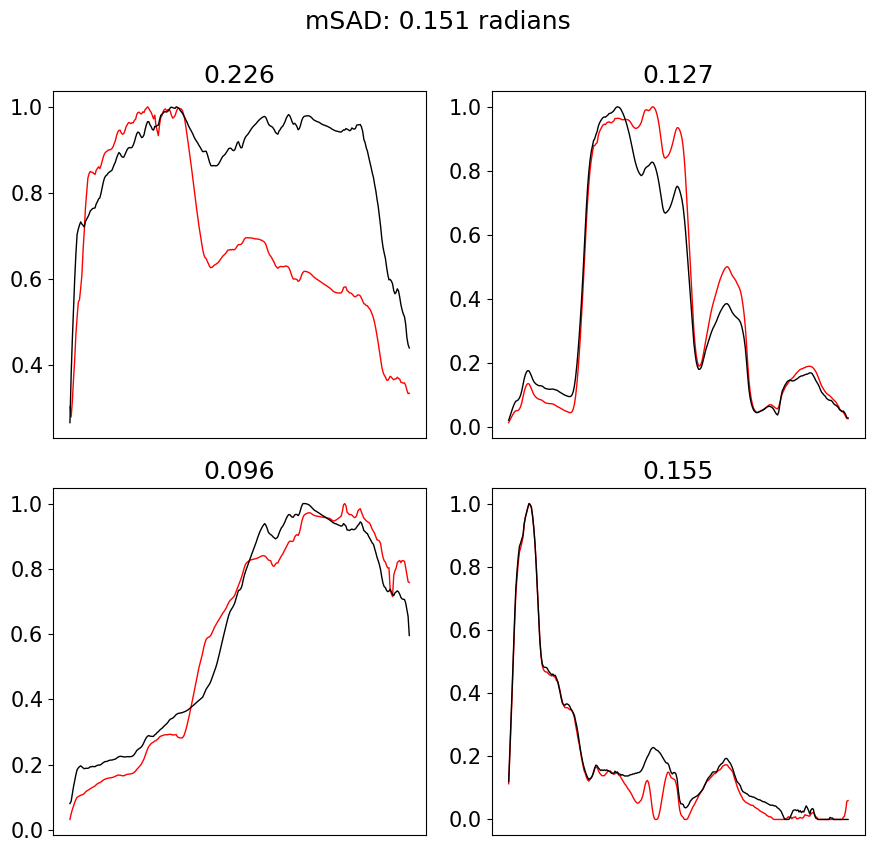

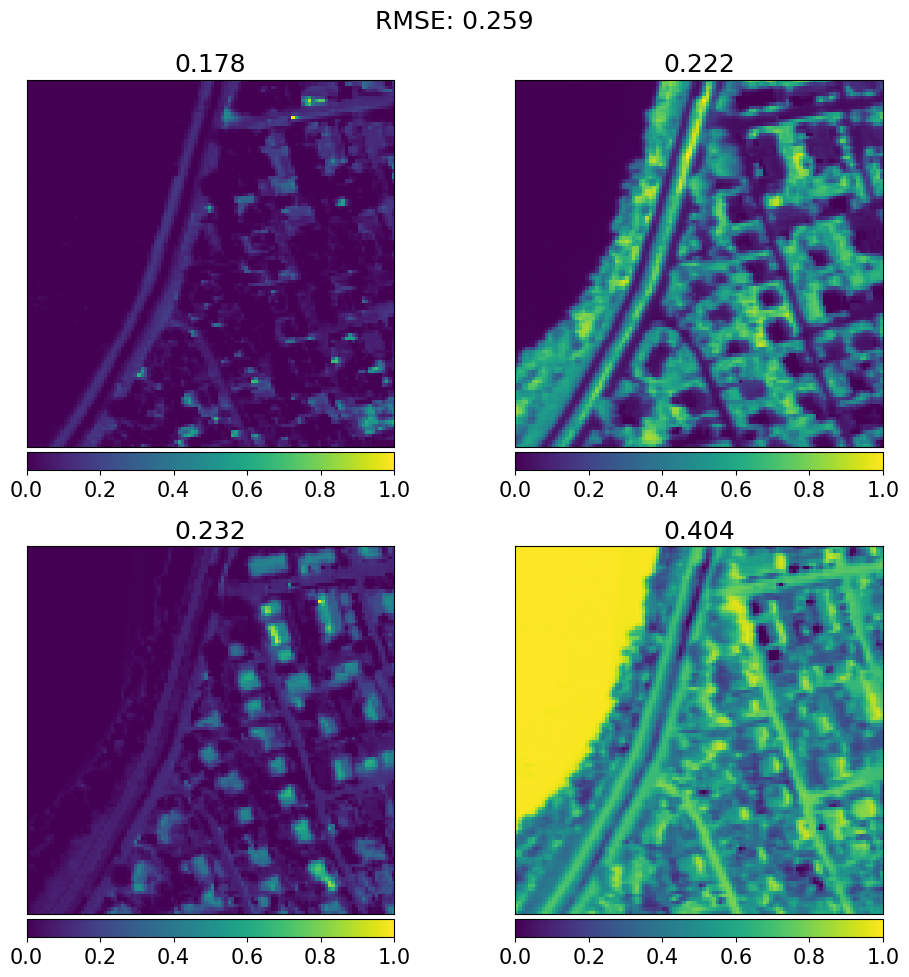

Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [ -5.246 -11.113   1.527 -20.89 ]
SNR improvement (dB): [ -1.315 -13.389   1.917  -1.559]
Per-endmember spatial entropy: [8.586  8.2645 8.9378 9.3106]
Mean per-pixel entropy: 0.7025
Times: fit 21.07s, fcls 52.15s, total_since_start 73.38s; GPU peak 0.0, CPU RSS 992.66015625
NFINDR run 2/5 seed=2


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


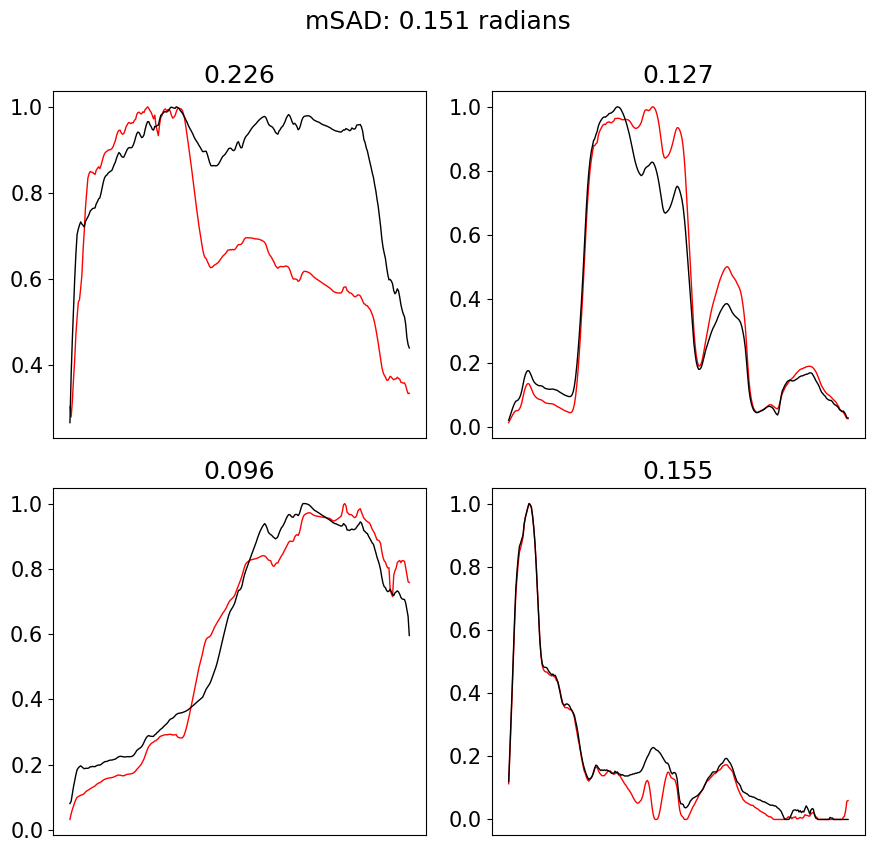

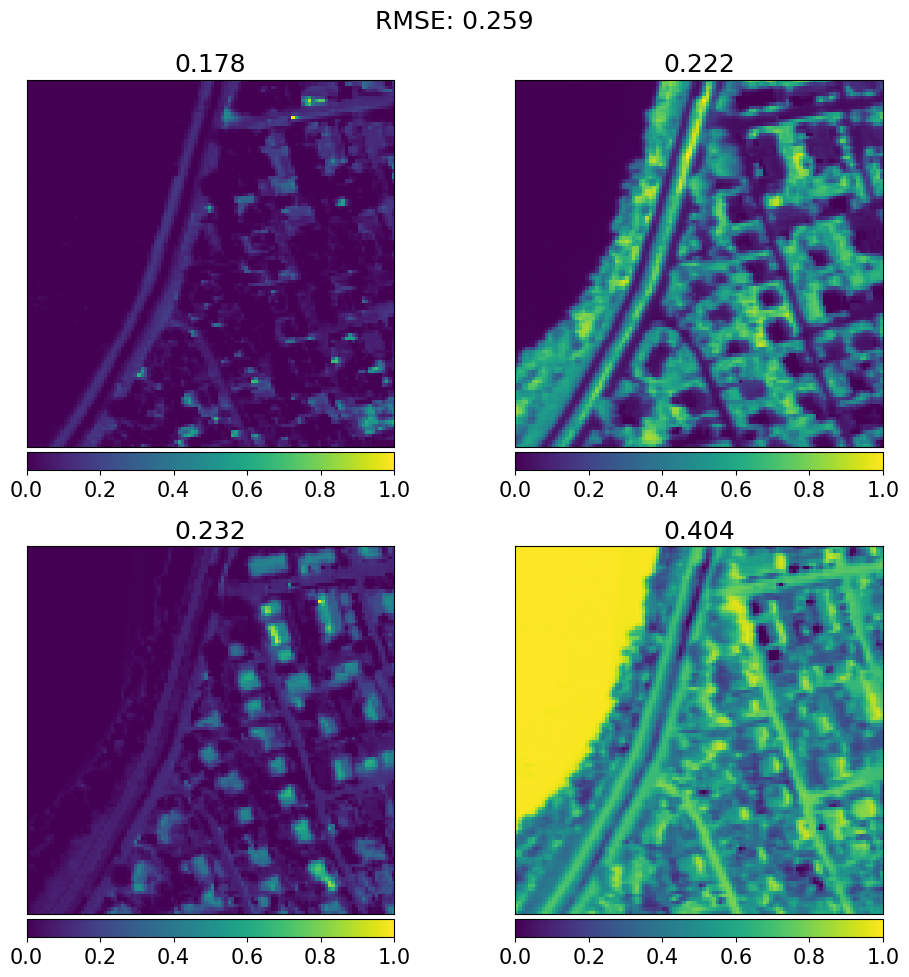

Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [ -5.246 -11.113 -28.266   3.83 ]
SNR improvement (dB): [ -1.315 -13.389 -27.876  23.161]
Per-endmember spatial entropy: [8.586  8.2645 9.3106 8.9378]
Mean per-pixel entropy: 0.7025
Times: fit 18.72s, fcls 49.97s, total_since_start 147.73s; GPU peak 0.0, CPU RSS 994.94140625
NFINDR run 3/5 seed=3


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


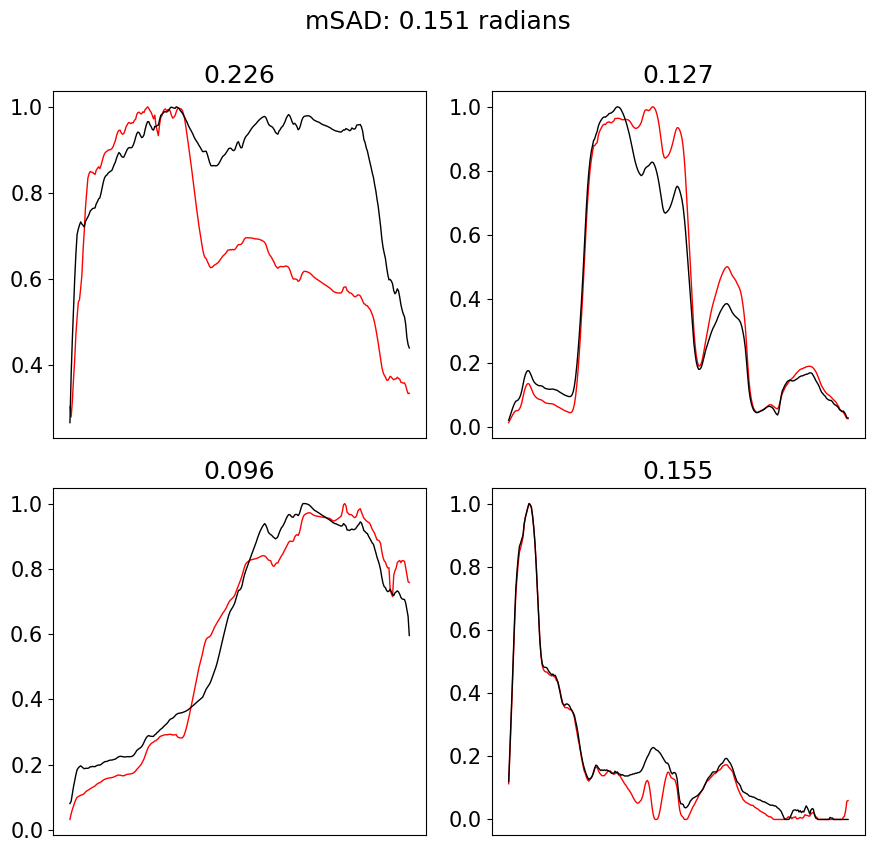

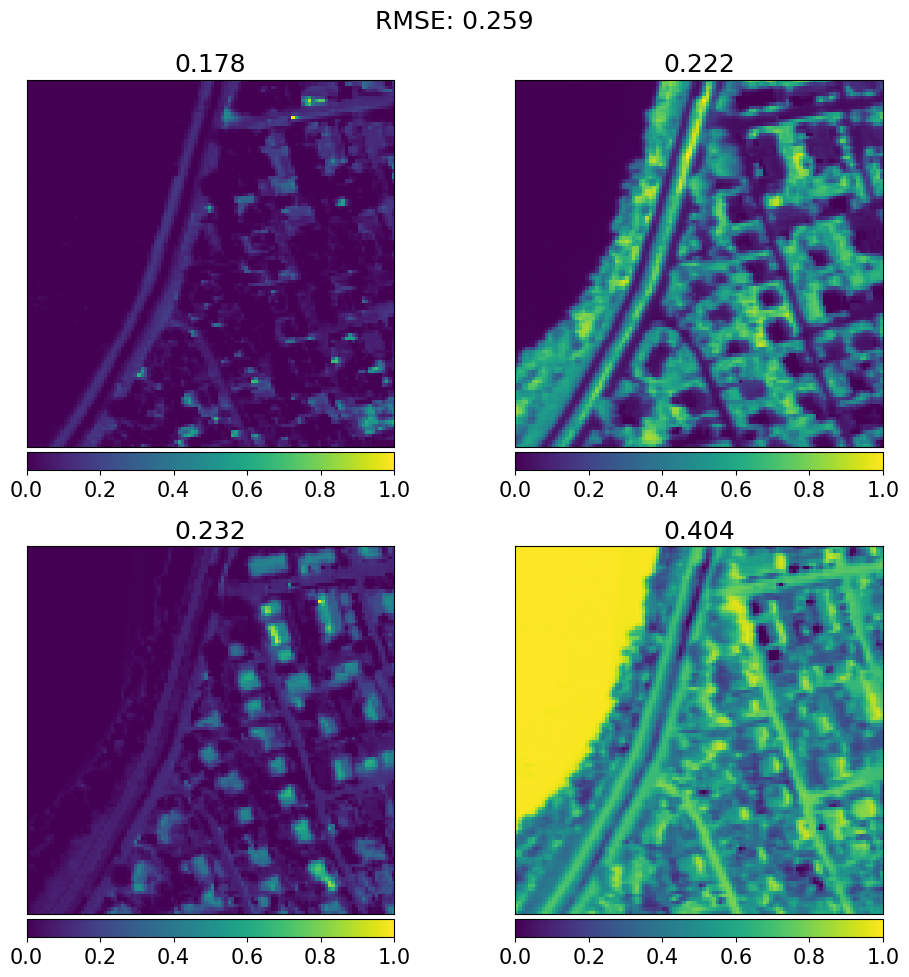

Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [-12.809 -27.028   1.527  -6.999]
SNR improvement (dB): [ -8.878 -29.304   1.917  12.332]
Per-endmember spatial entropy: [8.2645 9.3106 8.9378 8.586 ]
Mean per-pixel entropy: 0.7025
Times: fit 21.32s, fcls 50.07s, total_since_start 224.55s; GPU peak 0.0, CPU RSS 1019.2421875
NFINDR run 4/5 seed=4


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


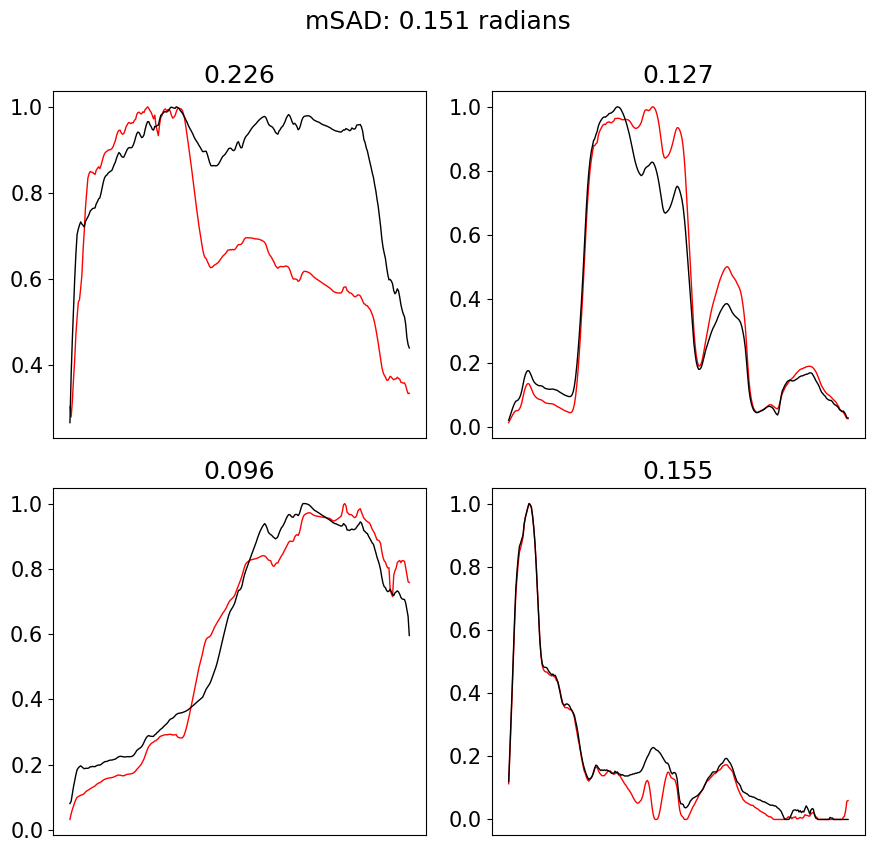

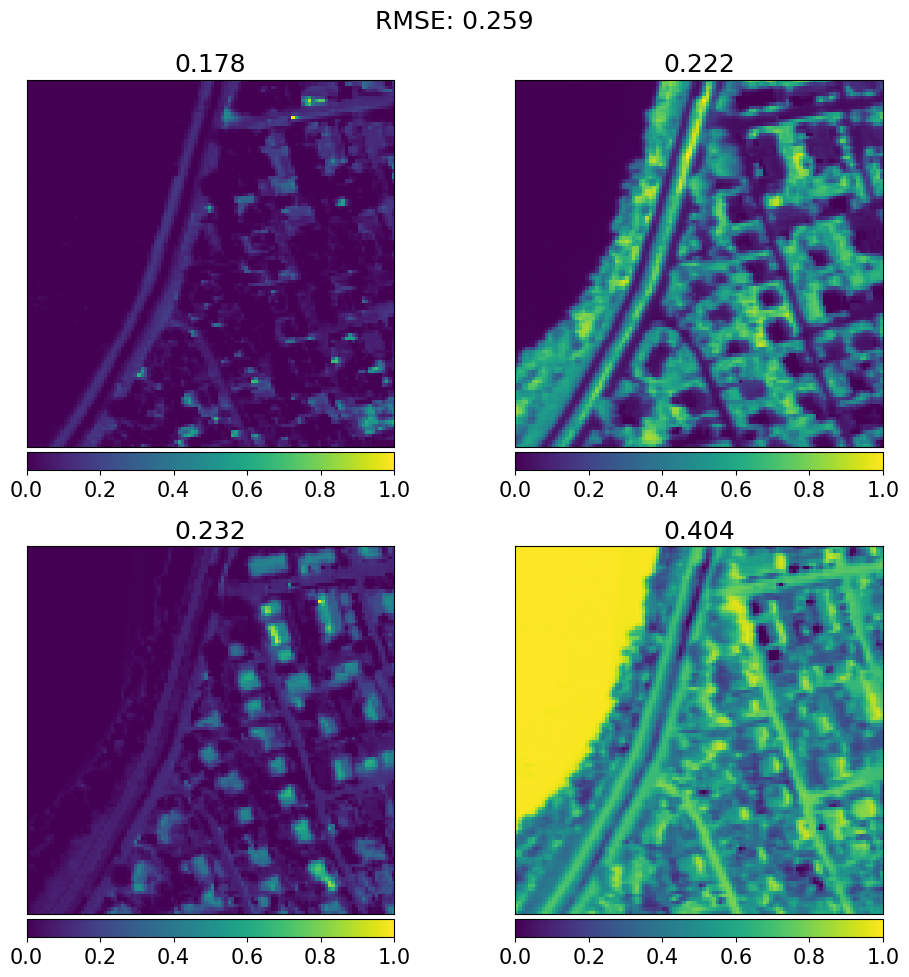

Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [ -5.246 -11.113   1.527 -20.89 ]
SNR improvement (dB): [ -1.315 -13.389   1.917  -1.559]
Per-endmember spatial entropy: [8.586  8.2645 8.9378 9.3106]
Mean per-pixel entropy: 0.7025
Times: fit 21.33s, fcls 48.93s, total_since_start 300.65s; GPU peak 0.0, CPU RSS 1019.42578125
NFINDR run 5/5 seed=5


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


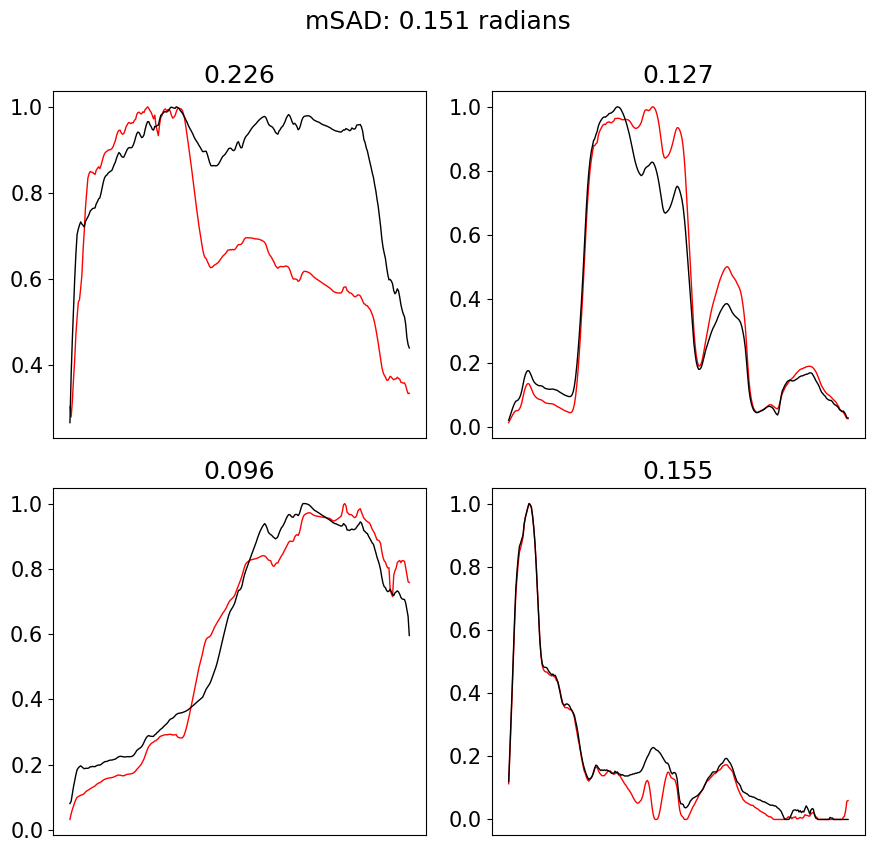

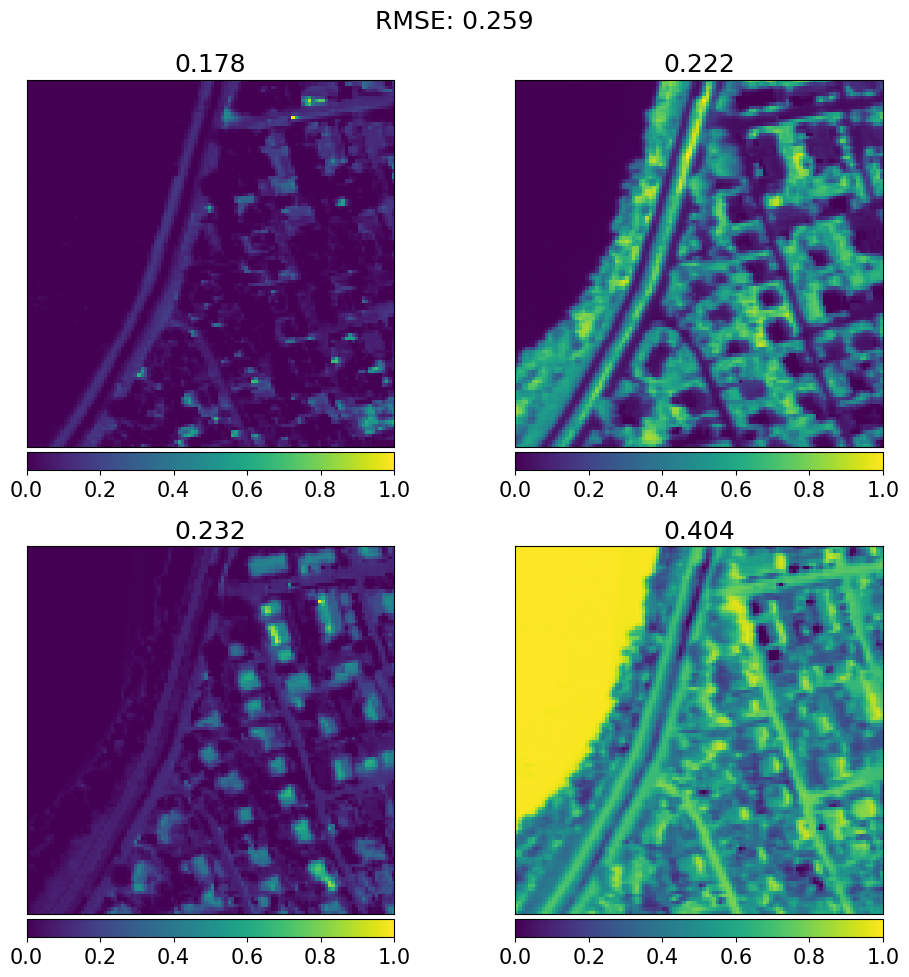

Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [-12.809 -27.028  -5.178   3.83 ]
SNR improvement (dB): [ -8.878 -29.304  -4.789  23.161]
Per-endmember spatial entropy: [8.2645 9.3106 8.586  8.9378]
Mean per-pixel entropy: 0.7025
Times: fit 17.32s, fcls 49.02s, total_since_start 371.76s; GPU peak 0.0, CPU RSS 1035.578125


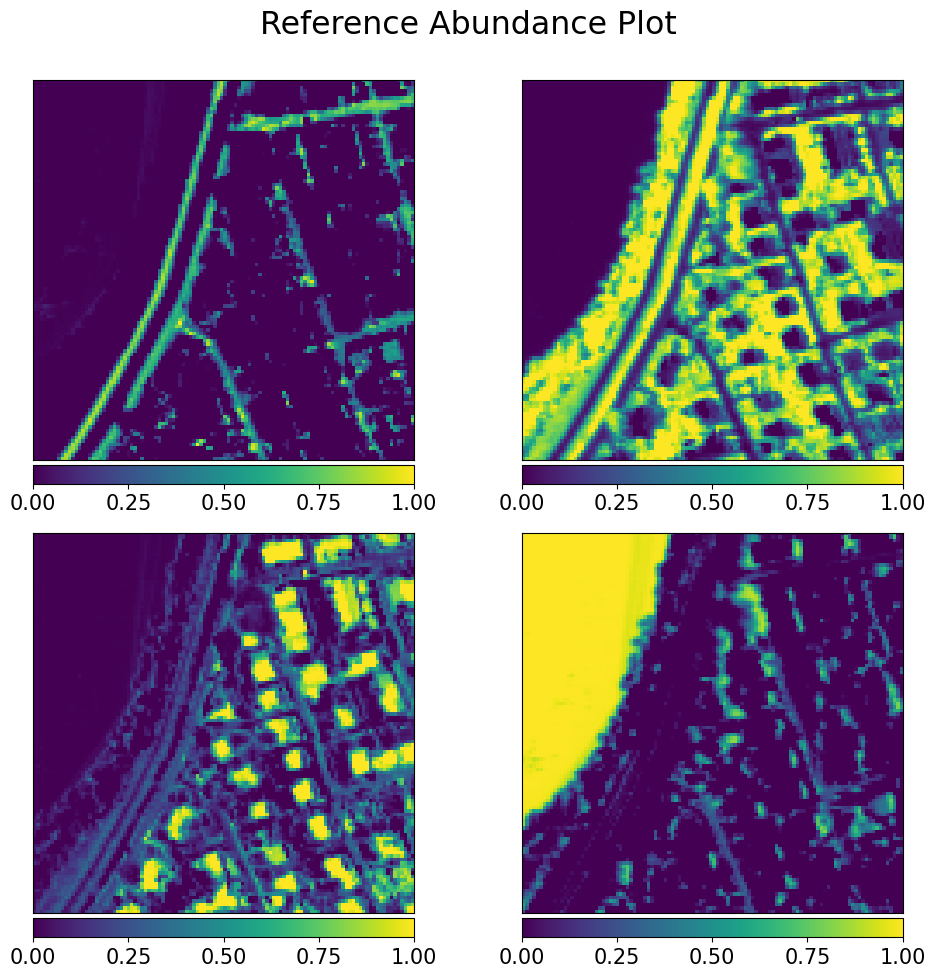

NFINDR finished. Results saved to: /content/drive/MyDrive/AM101/outputs/NFINDR/Apex


In [ ]:
runner = NFINDRRunner(dataset='Apex', DATASET_PATH=DATASET_PATH, OUTPUT_PATH=OUTPUT_PATH,
                      device='cuda', n_restarts=10, max_iter=5)
results_samson = runner.run(runs=5, seeds=[1,2,3,4,5])

## PMM

Starting PMMRunner.run(...) — this may print SVI progress.
PCA reduced to D=3 ; features mean [-0.  0. -0.], std [1.7184  1.09387 0.36062]

PMM run 1/5 seed=1 inference=svi device=cpu
PCA reduced to D=3 ; features mean [-0.  0. -0.], std [1.7184  1.09387 0.36062]
Running SVI (variational inference)...
SVI step 1/1200 loss=3.015598e+06
SVI step 120/1200 loss=1.109830e+06
SVI step 240/1200 loss=4.682112e+05
SVI step 360/1200 loss=2.942711e+05
SVI step 480/1200 loss=2.109429e+05
SVI step 600/1200 loss=1.307312e+05
SVI step 720/1200 loss=1.074412e+05
SVI step 840/1200 loss=9.439967e+04
SVI step 960/1200 loss=8.575284e+04
SVI step 1080/1200 loss=8.525482e+04
SVI step 1200/1200 loss=7.931278e+04
Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [  0.56  -18.626   0.637 -15.811]
SNR improvement (dB): [  4.49  -20.903   1.026   3.52 ]
Per-endmember spatial entropy: [9.1458 9.0404 9.1348 9.1175]
Mean per-pixel entropy: 1.0888
Times: fit 524.11s, fcl

/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


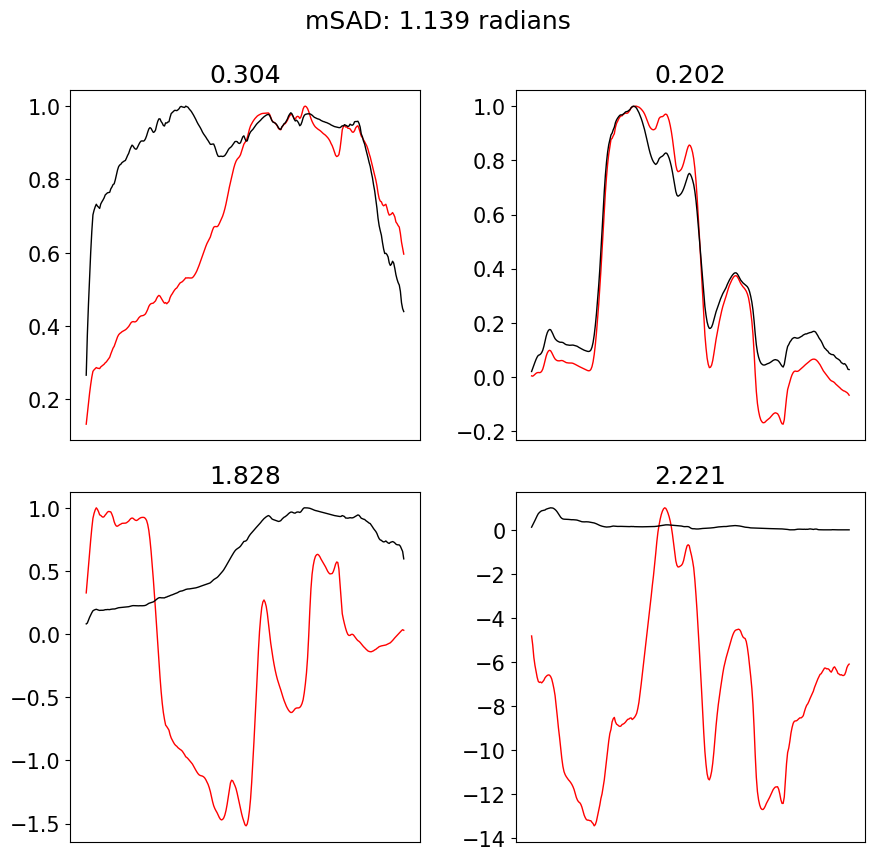

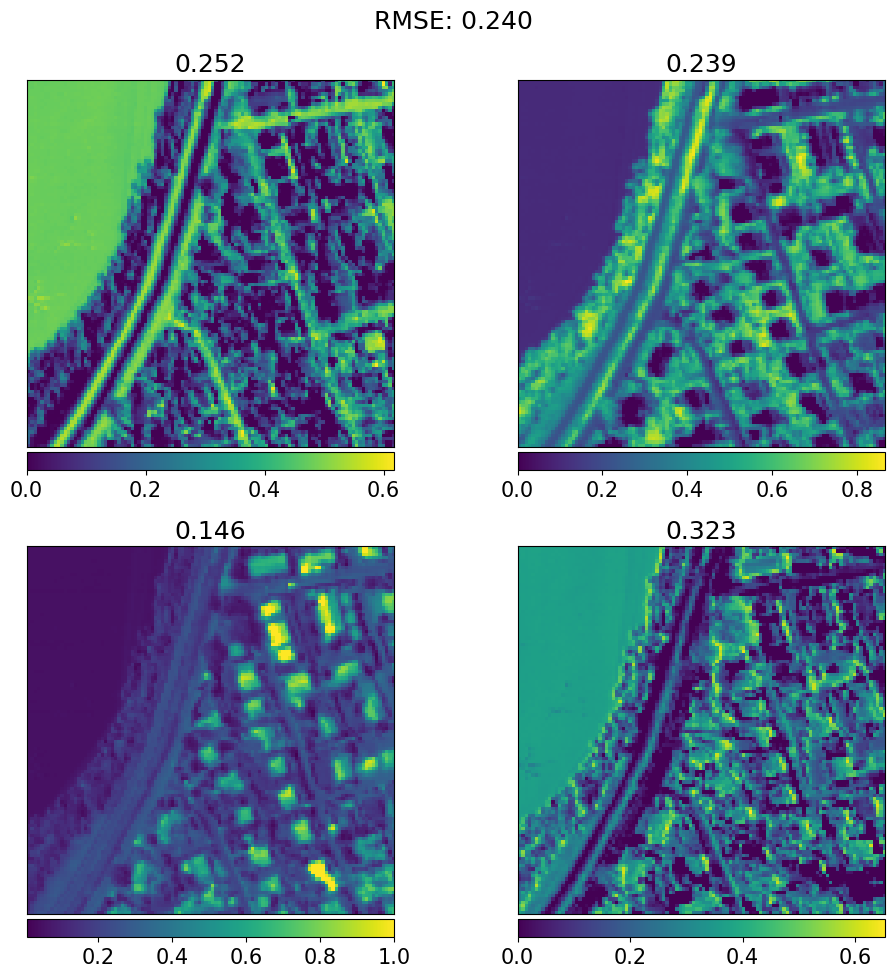


PMM run 2/5 seed=2 inference=svi device=cpu
PCA reduced to D=3 ; features mean [-0.  0. -0.], std [1.7184  1.09387 0.36062]
Running SVI (variational inference)...
SVI step 1/1200 loss=3.015598e+06
SVI step 120/1200 loss=1.109830e+06
SVI step 240/1200 loss=4.682112e+05
SVI step 360/1200 loss=2.942711e+05
SVI step 480/1200 loss=2.109429e+05
SVI step 600/1200 loss=1.307312e+05
SVI step 720/1200 loss=1.074412e+05
SVI step 840/1200 loss=9.439967e+04
SVI step 960/1200 loss=8.575284e+04
SVI step 1080/1200 loss=8.525482e+04
SVI step 1200/1200 loss=7.931278e+04
Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [  0.56  -18.626   0.637 -15.811]
SNR improvement (dB): [  4.49  -20.903   1.026   3.52 ]
Per-endmember spatial entropy: [9.1458 9.0404 9.1348 9.1175]
Mean per-pixel entropy: 1.0888
Times: fit 449.51s, fcls 45.37s, total_since_start 494.88s; GPU peak 0.0, CPU RSS 4226.3515625


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


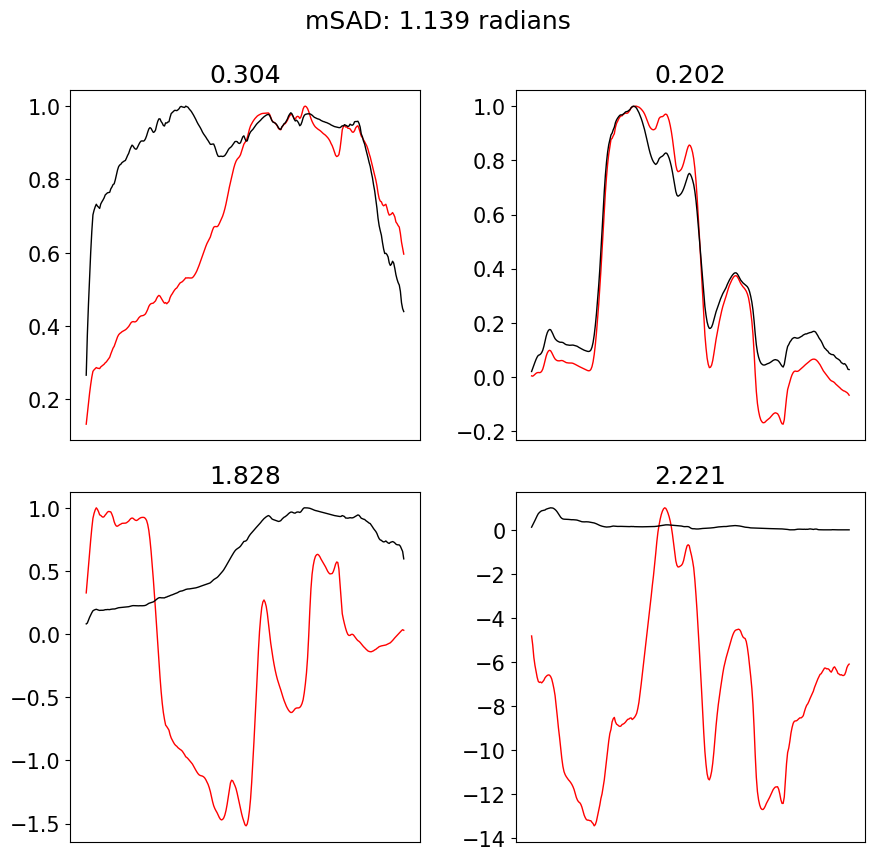

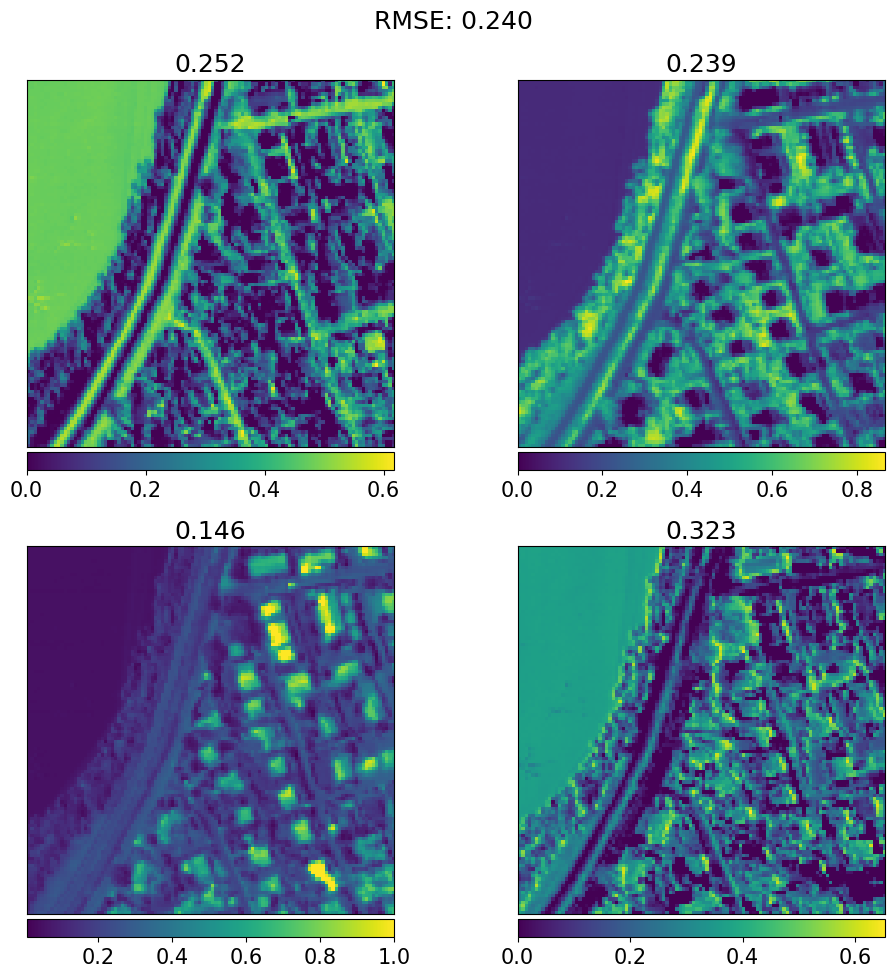


PMM run 3/5 seed=3 inference=svi device=cpu
PCA reduced to D=3 ; features mean [-0.  0. -0.], std [1.7184  1.09387 0.36062]
Running SVI (variational inference)...
SVI step 1/1200 loss=3.015598e+06
SVI step 120/1200 loss=1.109830e+06
SVI step 240/1200 loss=4.682112e+05
SVI step 360/1200 loss=2.942711e+05
SVI step 480/1200 loss=2.109429e+05
SVI step 600/1200 loss=1.307312e+05
SVI step 720/1200 loss=1.074412e+05
SVI step 840/1200 loss=9.439967e+04
SVI step 960/1200 loss=8.575284e+04
SVI step 1080/1200 loss=8.525482e+04
SVI step 1200/1200 loss=7.931278e+04
Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [  0.56  -18.626   0.637 -15.811]
SNR improvement (dB): [  4.49  -20.903   1.026   3.52 ]
Per-endmember spatial entropy: [9.1458 9.0404 9.1348 9.1175]
Mean per-pixel entropy: 1.0888
Times: fit 389.55s, fcls 45.10s, total_since_start 434.65s; GPU peak 0.0, CPU RSS 4222.08203125


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


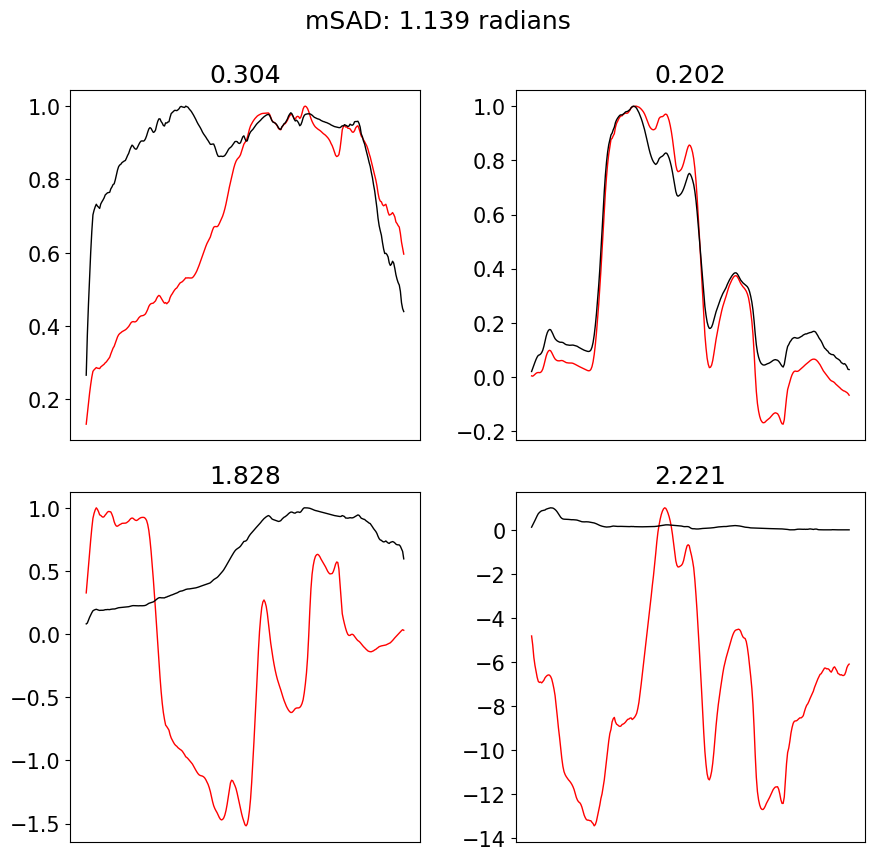

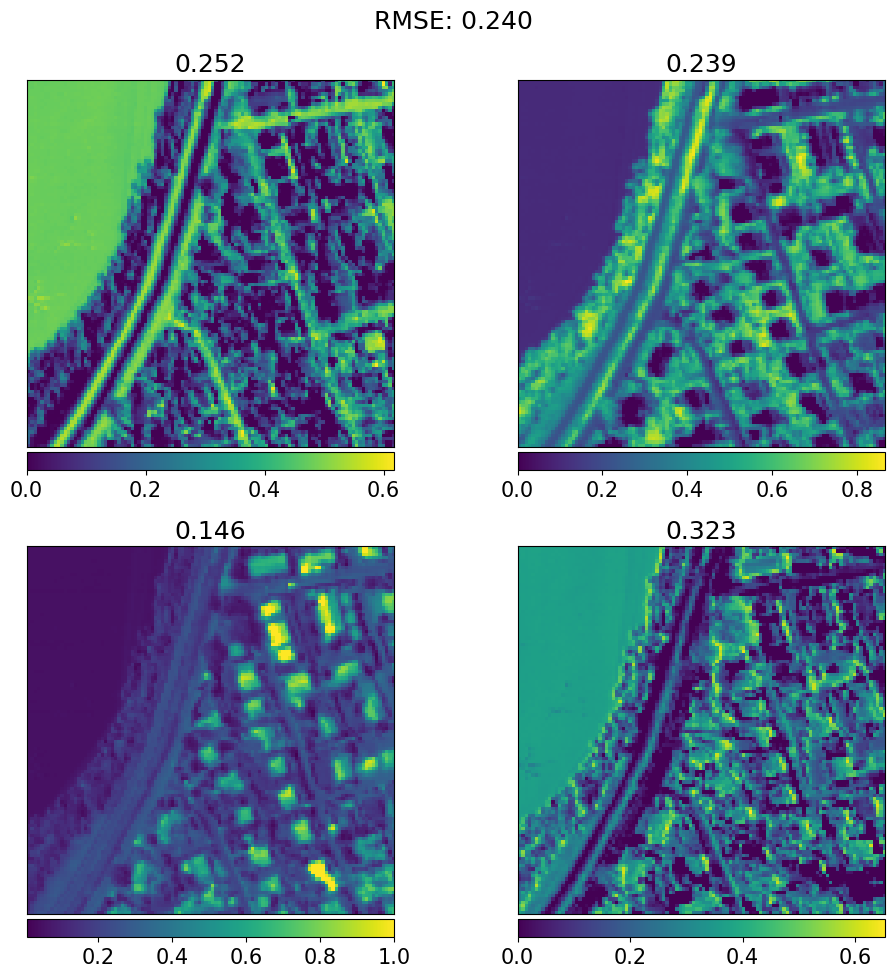


PMM run 4/5 seed=4 inference=svi device=cpu
PCA reduced to D=3 ; features mean [-0.  0. -0.], std [1.7184  1.09387 0.36062]
Running SVI (variational inference)...
SVI step 1/1200 loss=3.015598e+06
SVI step 120/1200 loss=1.109830e+06
SVI step 240/1200 loss=4.682112e+05
SVI step 360/1200 loss=2.942711e+05
SVI step 480/1200 loss=2.109429e+05
SVI step 600/1200 loss=1.307312e+05
SVI step 720/1200 loss=1.074412e+05
SVI step 840/1200 loss=9.439967e+04
SVI step 960/1200 loss=8.575284e+04
SVI step 1080/1200 loss=8.525482e+04
SVI step 1200/1200 loss=7.931278e+04
Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [  0.56  -18.626   0.637 -15.811]
SNR improvement (dB): [  4.49  -20.903   1.026   3.52 ]
Per-endmember spatial entropy: [9.1458 9.0404 9.1348 9.1175]
Mean per-pixel entropy: 1.0888
Times: fit 381.85s, fcls 43.96s, total_since_start 425.81s; GPU peak 0.0, CPU RSS 4222.11328125


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


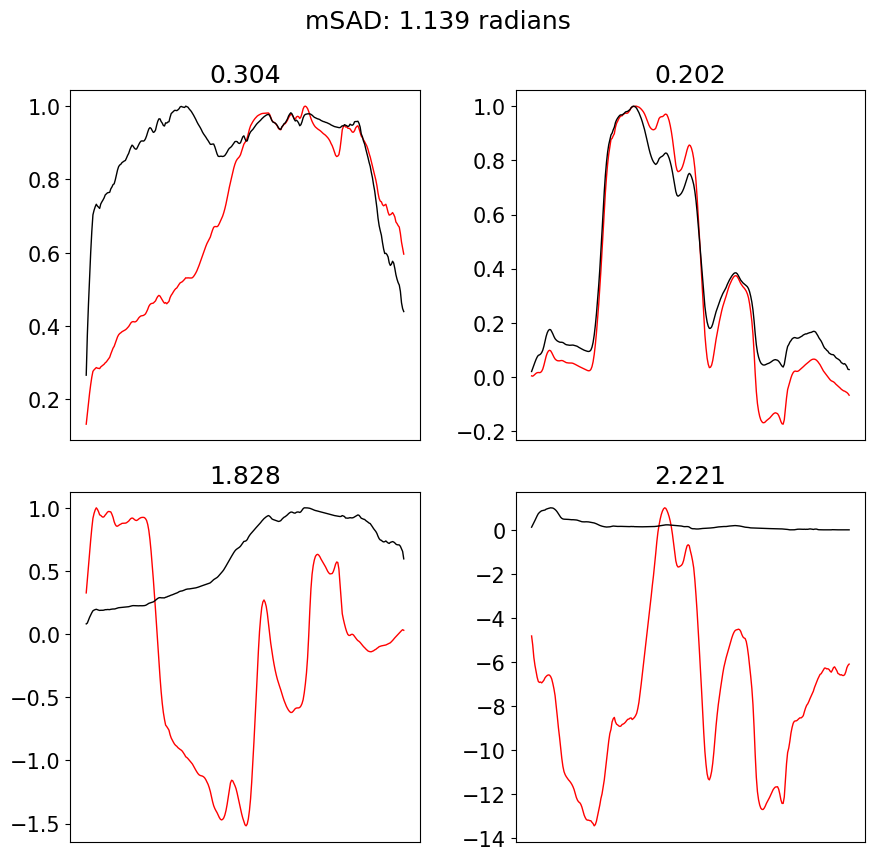

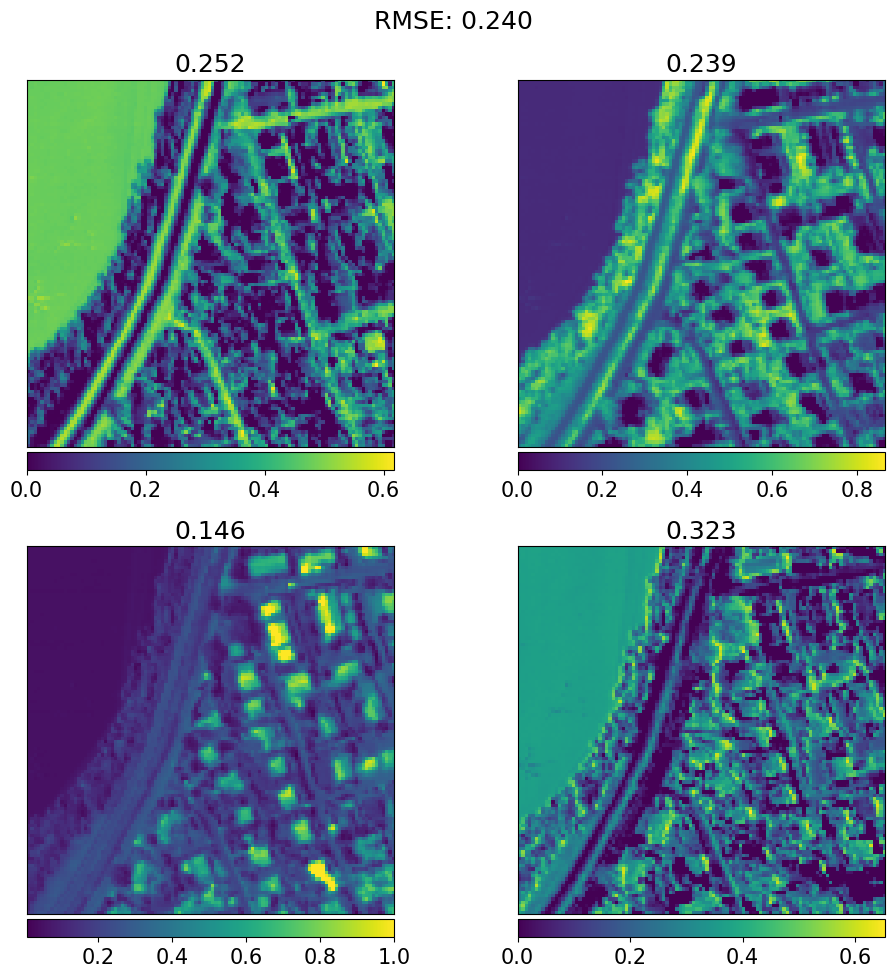


PMM run 5/5 seed=5 inference=svi device=cpu
PCA reduced to D=3 ; features mean [-0.  0. -0.], std [1.7184  1.09387 0.36062]
Running SVI (variational inference)...
SVI step 1/1200 loss=3.015598e+06
SVI step 120/1200 loss=1.109830e+06
SVI step 240/1200 loss=4.682112e+05
SVI step 360/1200 loss=2.942711e+05
SVI step 480/1200 loss=2.109429e+05
SVI step 600/1200 loss=1.307312e+05
SVI step 720/1200 loss=1.074412e+05
SVI step 840/1200 loss=9.439967e+04
SVI step 960/1200 loss=8.575284e+04
SVI step 1080/1200 loss=8.525482e+04
SVI step 1200/1200 loss=7.931278e+04
Per-endmember SNR before (dB): [ -3.931   2.276  -0.389 -19.331]
Per-endmember SNR after  (dB): [  0.56  -18.626   0.637 -15.811]
SNR improvement (dB): [  4.49  -20.903   1.026   3.52 ]
Per-endmember spatial entropy: [9.1458 9.0404 9.1348 9.1175]
Mean per-pixel entropy: 1.0888
Times: fit 391.60s, fcls 47.59s, total_since_start 439.19s; GPU peak 0.0, CPU RSS 4028.47265625


/tmp/ipython-input-2977875508.py:65: RuntimeWarning: invalid value encountered in scalar divide
  cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))


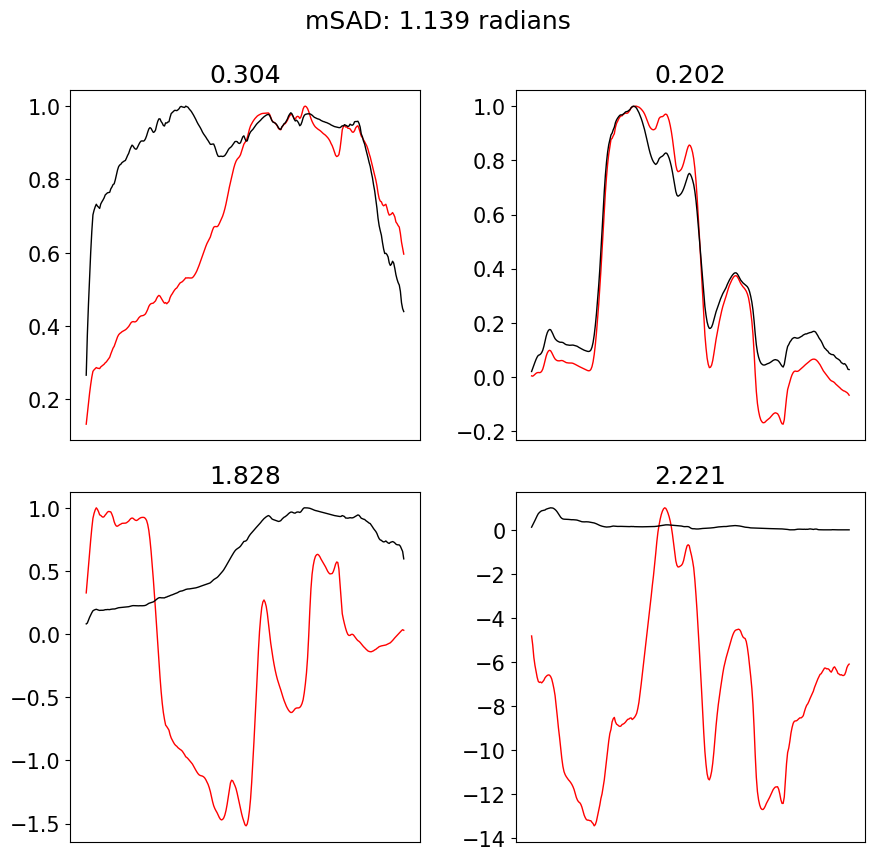

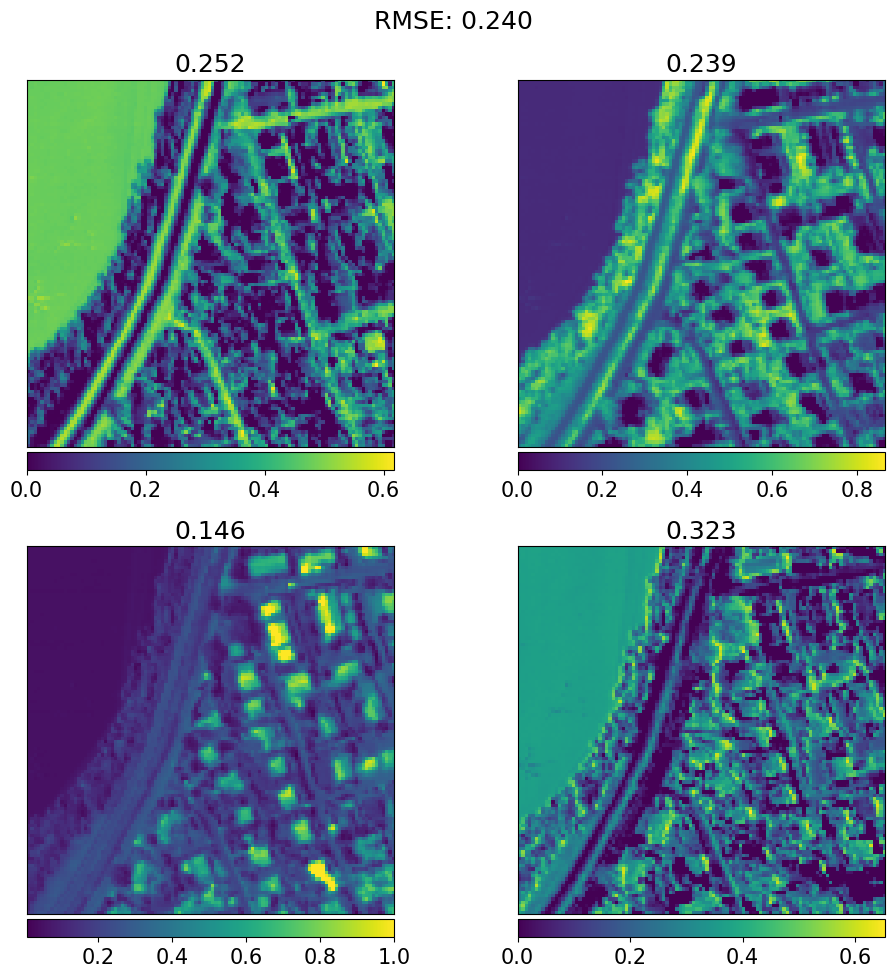

PMMRunner finished. Total elapsed time (s): 2375.34516787529

PMMRunner finished successfully. Summary keys:
['snr_before_mean', 'snr_before_std', 'snr_after_mean', 'snr_after_std', 'entropy_mean', 'entropy_std', 'pixel_entropy_mean', 'pixel_entropy_std', 'sad_mean', 'sad_std', 'ab_rmse_mean', 'ab_rmse_std', 're_mean', 're_std', 'elapsed']
snr_before_mean: [ -3.93071413   2.27626944  -0.38941056 -19.33070755]
snr_after_mean: [  0.55958067 -18.62647255   0.6370726  -15.81097219]


In [ ]:
# --- helper: ensure dataset/output paths exist ---
import traceback
def fcls_pixel(y, M, tol=1e-8):
    """
    y : (bands,)
    M : (P, bands)  endmembers as rows
    returns: a (P,) abundance (>=0, sum==1)
    """
    y = np.asarray(y).reshape(-1)
    M = np.asarray(M)
    P = M.shape[0]
    A = M.T  # bands x P

    # nnls initialization fallback
    try:
        from scipy.optimize import nnls
        x_nnls, _ = nnls(A, y)
        if x_nnls.sum() <= 0:
            a0 = np.ones(P) / P
        else:
            a0 = x_nnls / (x_nnls.sum() + 1e-12)
    except Exception:
        a0 = np.ones(P) / P

    def obj(a):
        r = A.dot(a) - y
        return float(np.sum(r * r))

    cons = ({'type': 'eq', 'fun': lambda a: np.sum(a) - 1.0})
    bounds = [(0.0, 1.0) for _ in range(P)]

    res = minimize(obj, a0, method='SLSQP', bounds=bounds, constraints=cons,
                   options={'ftol': 1e-9, 'maxiter': 200, 'disp': False})
    if not res.success:
        a = np.clip(a0, 0, None)
        s = a.sum()
        if s <= 0:
            a = np.ones(P) / P
        else:
            a = a / s
    else:
        a = res.x
    a = np.clip(a, 0.0, 1.0)
    a = a / (a.sum() + 1e-12)
    return a

def compute_abundances_fcls(Y, E, rows=None, cols=None, verbose=False):
    """
    Y: (pixels x bands)
    E: (P x bands) or (bands x P); will be interpreted.
    returns: (rows x cols x P) if rows/cols provided else (pixels x P)
    """
    Y = np.asarray(Y)
    E = np.asarray(E)
    if E.shape[0] != Y.shape[1] and E.shape[1] == Y.shape[1]:
        # E likely (bands x P)
        E_use = E.T  # (P x bands)
    elif E.shape[0] == Y.shape[1] and E.shape[1] != Y.shape[1]:
        E_use = E.T
    else:
        E_use = E if E.shape[1] == Y.shape[1] else E.T

    P = E_use.shape[0]
    pixels = Y.shape[0]
    A_pix = np.zeros((pixels, P), dtype=float)
    for i in range(pixels):
        y = Y[i, :]
        A_pix[i, :] = fcls_pixel(y, E_use)
        if verbose and (i % 1000 == 0 and i > 0):
            print(f"FCLS: processed {i}/{pixels} pixels")
    if rows is not None and cols is not None:
        return A_pix.reshape(rows, cols, P)
    else:
        return A_pix

# If the real compute_abundances_fcls exists, prefer it
if 'compute_abundances_fcls' in globals():
    compute_abundances_fcls = globals()['compute_abundances_fcls']
else:
    globals()['compute_abundances_fcls'] = compute_abundances_fcls

# --- instantiate and run PMMRunner safely ---
try:
    # ensure pyro is available where PMMRunner expects it
    if not 'PYRO_AVAILABLE' in globals():
        print("Warning: PYRO_AVAILABLE flag not found; continuing and hoping pyro is importable.")
    import pyro  # will raise if pyro not installed

    runner = PMMRunner(
        dataset='Apex',
        DATASET_PATH=DATASET_PATH,
        OUTPUT_PATH=OUTPUT_PATH,
        device='cpu',                 # CPU run as requested
        inference='svi',              # 'svi' or 'mcmc'
        svi_steps=1200,
        svi_lr=5e-3,
        use_cholesky_prior=False,     # matches your call
        predictive_samples=200,
        save_samples=False,
        seed=1
    )

    print("Starting PMMRunner.run(...) — this may print SVI progress.")
    res = runner.run(runs=5, seeds=[1,2,3,4,5])
    print("\nPMMRunner finished successfully. Summary keys:")
    print(list(res.keys()))
    print("snr_before_mean:", res.get('snr_before_mean'))
    print("snr_after_mean:", res.get('snr_after_mean'))

except Exception as e:
    print("PMMRunner.run failed with exception:")
    traceback.print_exc()
    # show some env debug
    try:
        import torch
        print("torch device count:", torch.cuda.device_count(), "cuda available:", torch.cuda.is_available())
    except Exception:
        pass
    try:
        import pyro
        print("pyro version:", pyro.__version__)
    except Exception:
        print("pyro not importable.")
    raise